# Term Deposit Marketing - ML Case Study

---


**Project Overview:**

The goal of this case study is to predict whether a customer will subscribe to a term deposit product based on data collected from a direct marketing campaign conducted by a European bank. The campaign involved multiple call attempts to customers, and the focus is on improving the success rate of such calls by identifying the most likely responders.

**Data Description:**

- **age**: Age of the customer
- **job**: Type of job (e.g., admin, technician, blue-collar)
- **marital**: Marital status (e.g., married, single)
- **education**: Level of education
- **default**: Has credit in default (yes/no)
- **balance**: Average yearly account balance in euros
- **housing**: Has a housing loan (yes/no)
- **loan**: Has a personal loan (yes/no)
- **contact**: Contact communication type (e.g., cellular, telephone)
- **day**: Last contact day of the month
- **month**: Last contact month (e.g., may, jul)
- **duration**: Duration of the last contact in seconds
- **campaign**: Number of contact attempts made during the campaign
- **Target (y)**: Indicates if the customer subscribed to a term deposit (yes/no)

**Objective:**

Build a classification model that predicts term deposit subscriptions with at least 81% accuracy, evaluated via 5-fold cross-validation. Additionally, identify key customer segments and features most associated with successful subscriptions, providing actionable insights for marketing prioritization and decision-making.


----

#### Summary of the Notebook:

##### 1. [Exploratory Data Analysis](#eda)
##### 2. [Experimenting with Prediction Models](#model-training)
##### 3. [Feature Engineering](#feature-engineering)
##### 4. [Feature Selection](#feature-selection)
##### 5. [Optimize the model and hyperparameters](#hyperopt)
##### 6. [Additional Feature Engineering steps](#additional-feature-engineering)
##### 7. [Exploring Features and Models Combinations](#exploring-features-and-models-combinations)
##### 8. [Minimal Predictive Feature Set](#minimal-predictive-feature-set)
##### 9. [Shift in Focus: from Accuracy to Business-Driven Metrics](#shift-in-focus)
##### [General Conclusion and Business Insights](#conclusion)



----

<a id="eda"></a>
### 1 - Exploratory Data Analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('term-deposit-marketing-2020.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [4]:
df.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


#### **Check for duplicates and nulls:**

In [5]:
print(df.duplicated().sum())

0


In [6]:
nulls = df.isna().sum()
print(nulls)
print(f'\nTotal nulls: {nulls.sum()}')

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

Total nulls: 0


#### **Target Variable Analysis:**

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Target Class Distribution')

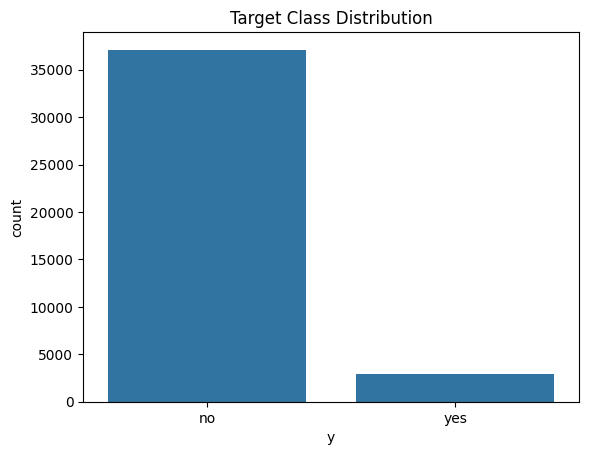

In [8]:
sns.countplot(x='y', data=df)
plt.title("Target Class Distribution")


In [9]:
# target values convertion
df['y'] = df['y'].map({'yes': 1, 'no':0})

In [10]:
df['y'].value_counts(normalize=True)

y
0    0.9276
1    0.0724
Name: proportion, dtype: float64

**Target Imbalance Observation:**

The target variable `y` is highly imbalanced, with approximately **92.76%** of the observations labeled as `no` (class 0) and only **7.24%** labeled as `yes` (class 1).  
This significant imbalance requires careful consideration, as relying solely on accuracy can be misleading. A model that always predicts the majority class would still achieve high accuracy without truly learning the underlying patterns.


#### **Features Analysis:**

Following, we present each feature representation:

##### **#1 - Age:**

In [89]:
def plot_facet_grid(feature, bins):
    g = sns.FacetGrid(df, col='y', height=5, aspect=1.2)
    g.map(sns.histplot, feature, bins=bins, color='#3498db', kde=False)
    g.set_titles(col_template='Target = {col_name}')
    g.set_axis_labels(feature, "Count")
    g.fig.suptitle(f"{feature} Distribution by Term Deposit Subscription", y=1.05)
    plt.tight_layout()
    plt.show()

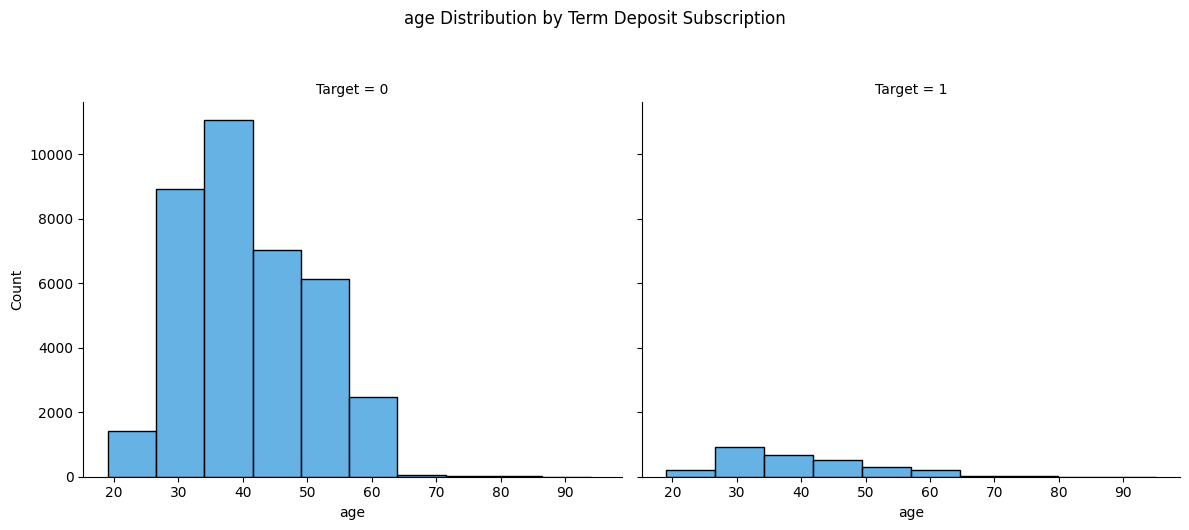

In [91]:
plot_facet_grid('age',10)

In [92]:
def plot_KDE(feature):
    # Kernel Density Estimation: estimate probability density function
    sns.kdeplot(data=df[df['y'] == 0], x=feature, label='No (0)', fill=True, color='#5DADE2')
    sns.kdeplot(data=df[df['y'] == 1], x=feature, label='Yes (1)', fill=True, color='#1ABC9C')
    plt.title(f"KDE of {feature} by Term Deposit Subscription")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


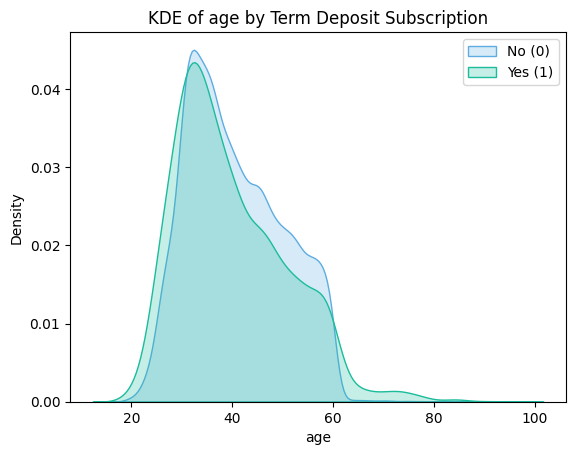

In [93]:
plot_KDE('age')

In [51]:
def plot_TargetbyCat(feature):

    job_counts_abs = pd.crosstab(df[feature], df['y']).sort_values(by=1, ascending=False)
    jobs = job_counts_abs.index
    counts_no = job_counts_abs[0]
    counts_yes = job_counts_abs[1]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_min_width = 200  # Threshold in pixels for switching label position
    
    bar_no = ax.barh(jobs, counts_no, color='#5DADE2', label='No (0)')
    bar_yes = ax.barh(jobs, counts_yes, left=counts_no, color='#1ABC9C', label='Yes (1)')
    

    # Add percentage labels (inside or outside logic)
    for i, (no, yes) in enumerate(zip(counts_no, counts_yes)):
        total = no + yes
        yes_pct = f'{yes / total:.1%}'
        no_pct = f'{no / total:.1%}'
    
        # No label: always inside (enough space)
        ax.text(no / 2, i, no_pct, va='center', ha='center', color='white', fontsize=9)
    
        # Yes label: decide based on bar width
        if yes > bar_min_width:
            # enough space: put inside
            ax.text(no + yes / 2, i, yes_pct, va='center', ha='center', color='white', fontsize=9)
        else:
            # too small: put outside
            ax.text(no + yes + 50, i, yes_pct, va='center', ha='left', color='black', fontsize=9)
    
    # Axis and styling
    ax.set_xlabel("Number of Records")
    ax.set_title(f"Term Deposit Subscriptions by {feature} (Absolute Count & Proportion)")
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


##### **#2 - Job:**

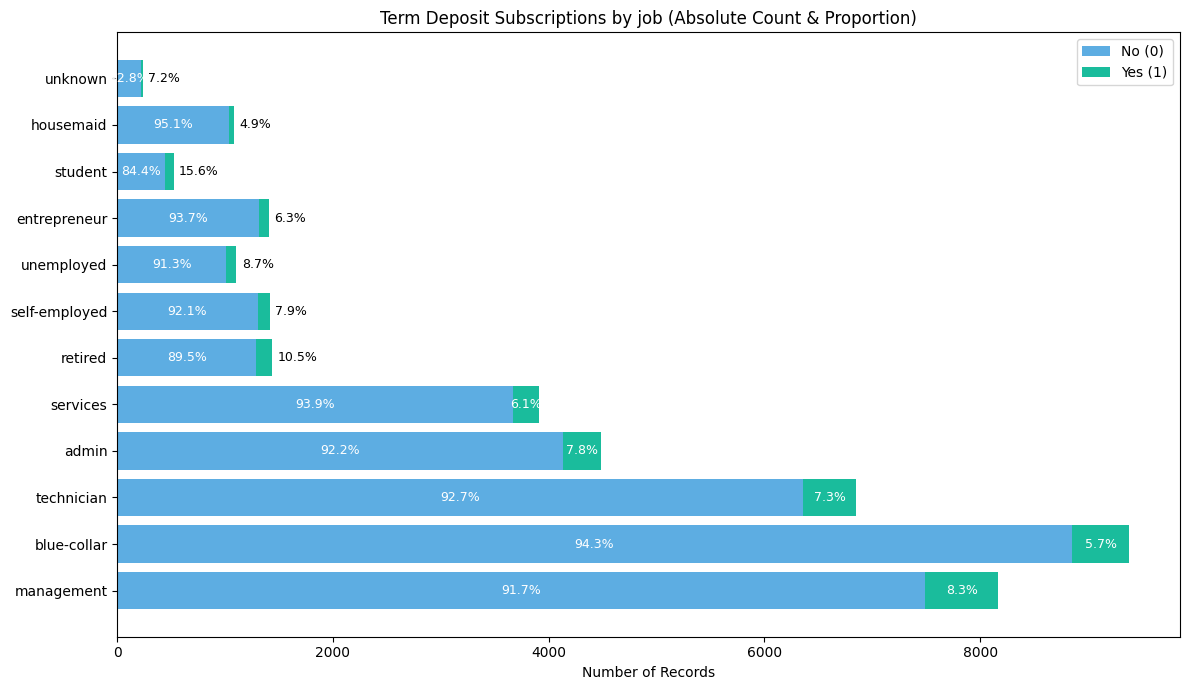

In [52]:
plot_TargetbyCat('job')

##### **#3 - Marital:**

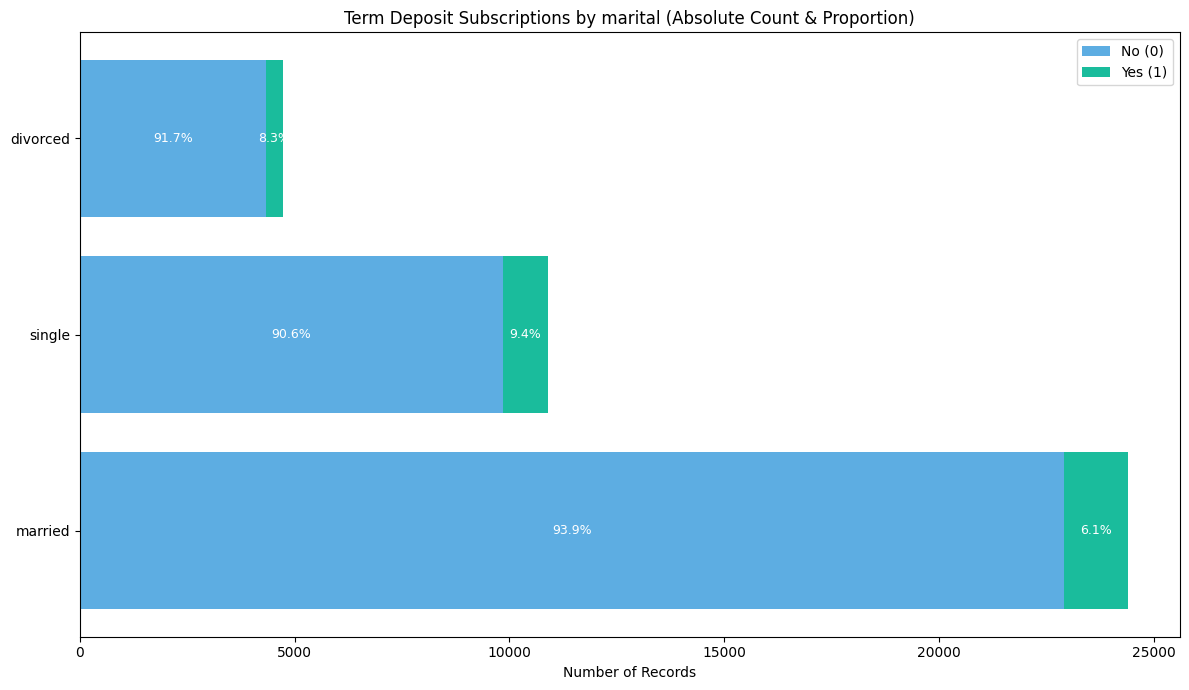

In [75]:
plot_TargetbyCat('marital')

##### **#4 - Education:**

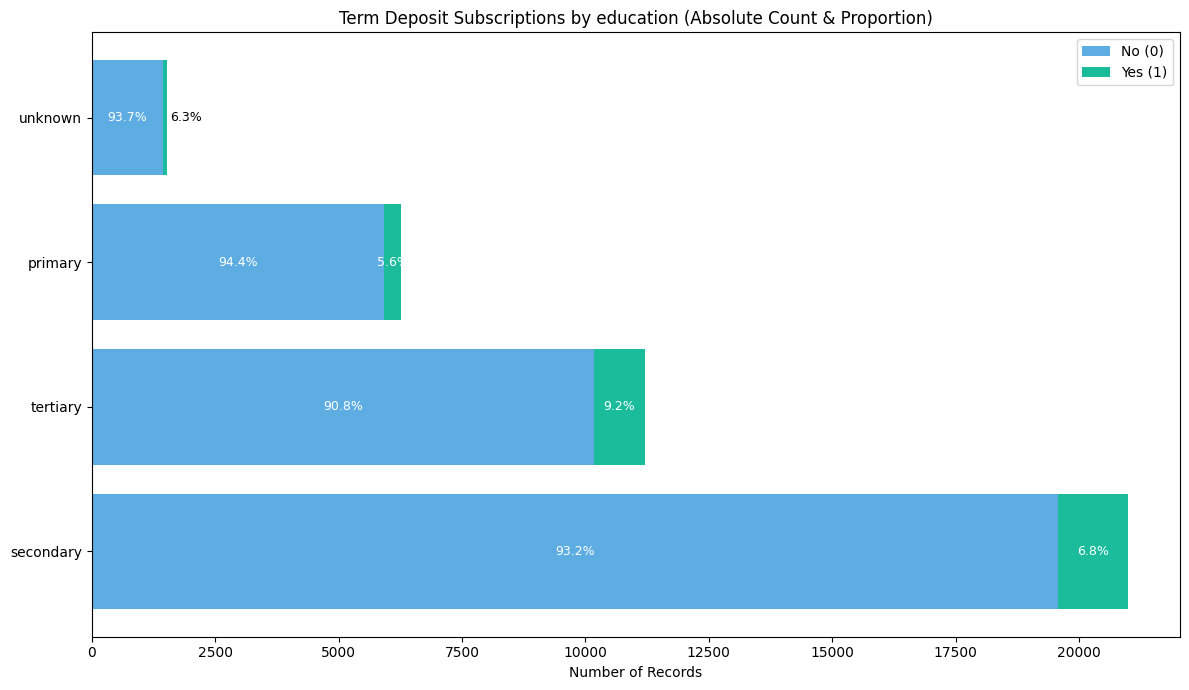

In [54]:
plot_TargetbyCat('education')

##### **#5 - Default:**

Has credit in default? (yes/no)


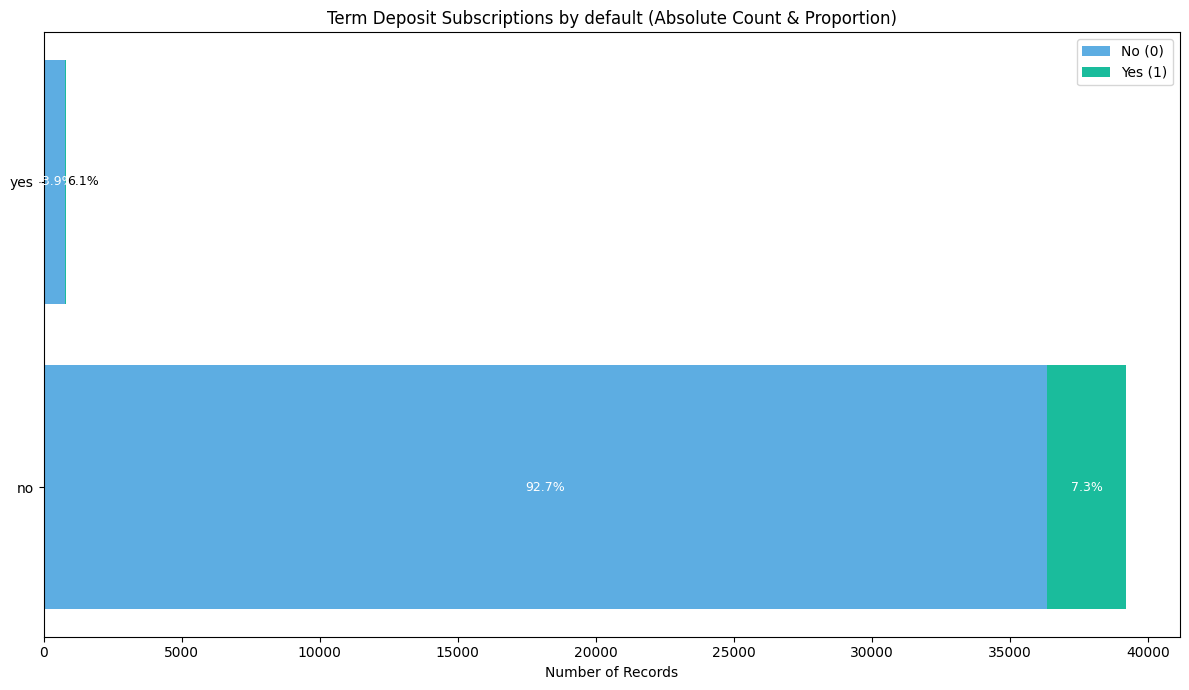

In [55]:
plot_TargetbyCat('default')

##### **#6 - balance**

In [94]:
plot_facet_grid('balance')

TypeError: plot_facet_grid() missing 1 required positional argument: 'bins'

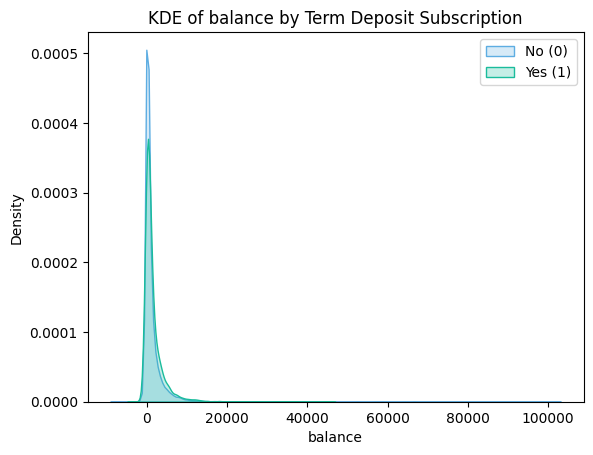

In [77]:
plot_KDE('balance')

##### **#7 - housing**

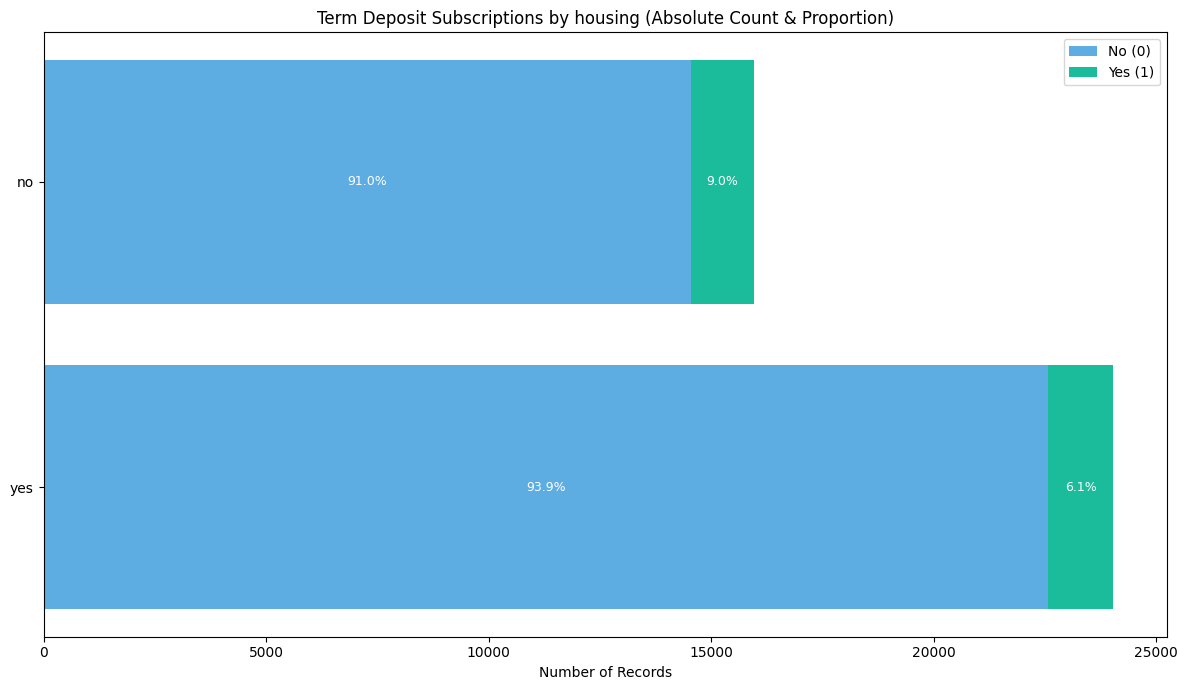

In [56]:
plot_TargetbyCat('housing')

##### **#8 - loan**

loan: Has a personal loan (yes/no)

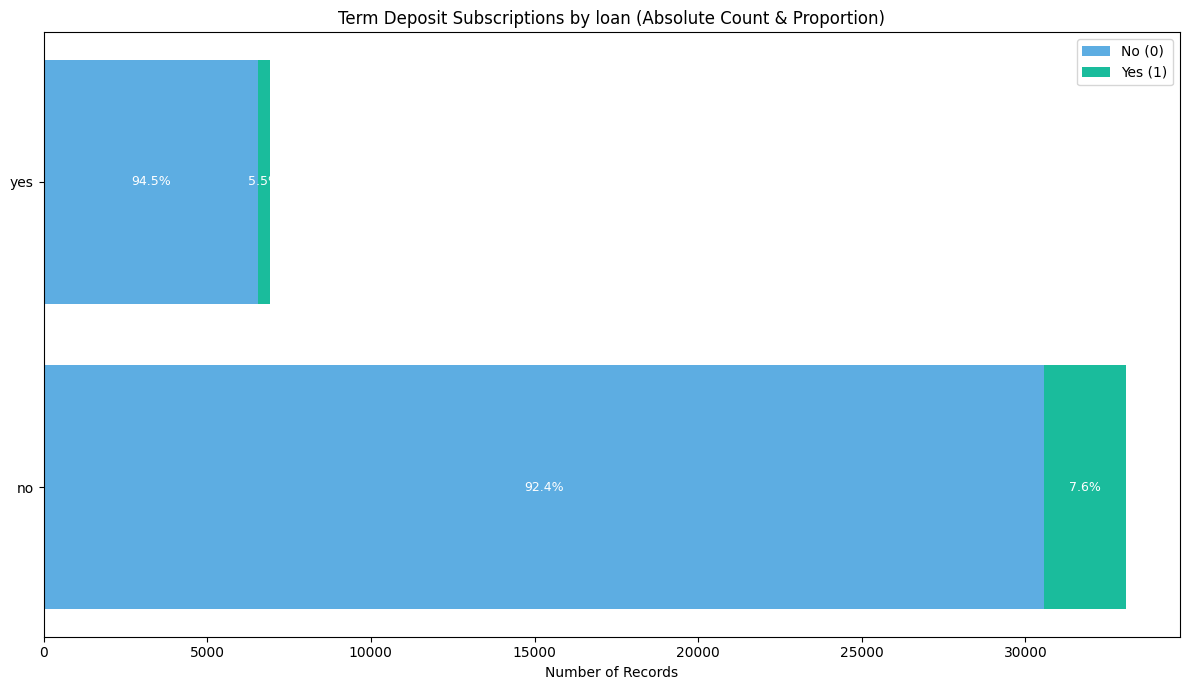

In [57]:
plot_TargetbyCat('loan')

##### **#9 - contact**

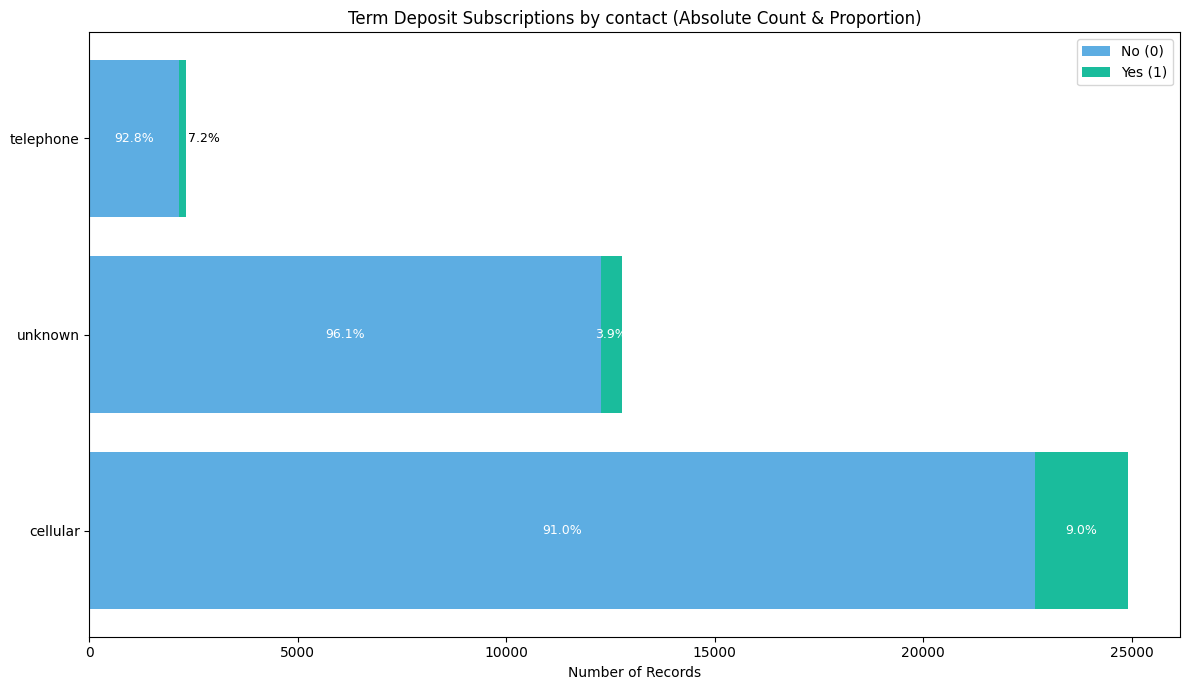

In [58]:
plot_TargetbyCat('contact')

##### **#10 - day**

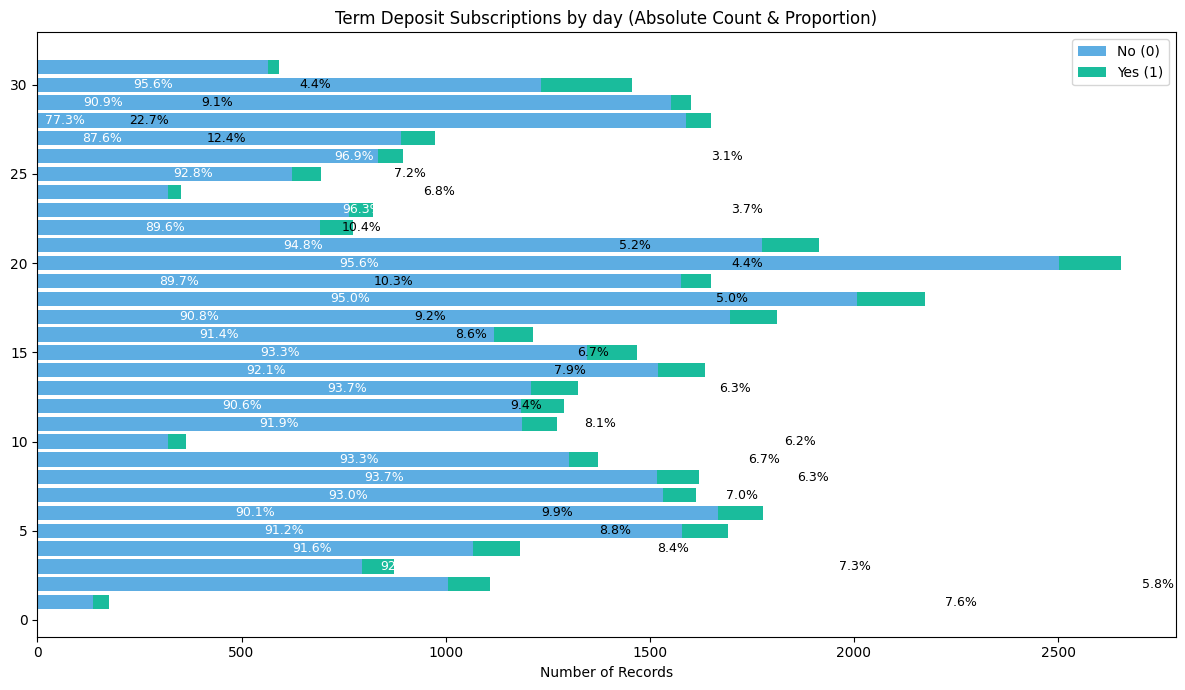

In [86]:
plot_TargetbyCat('day')

##### **#11 - month**

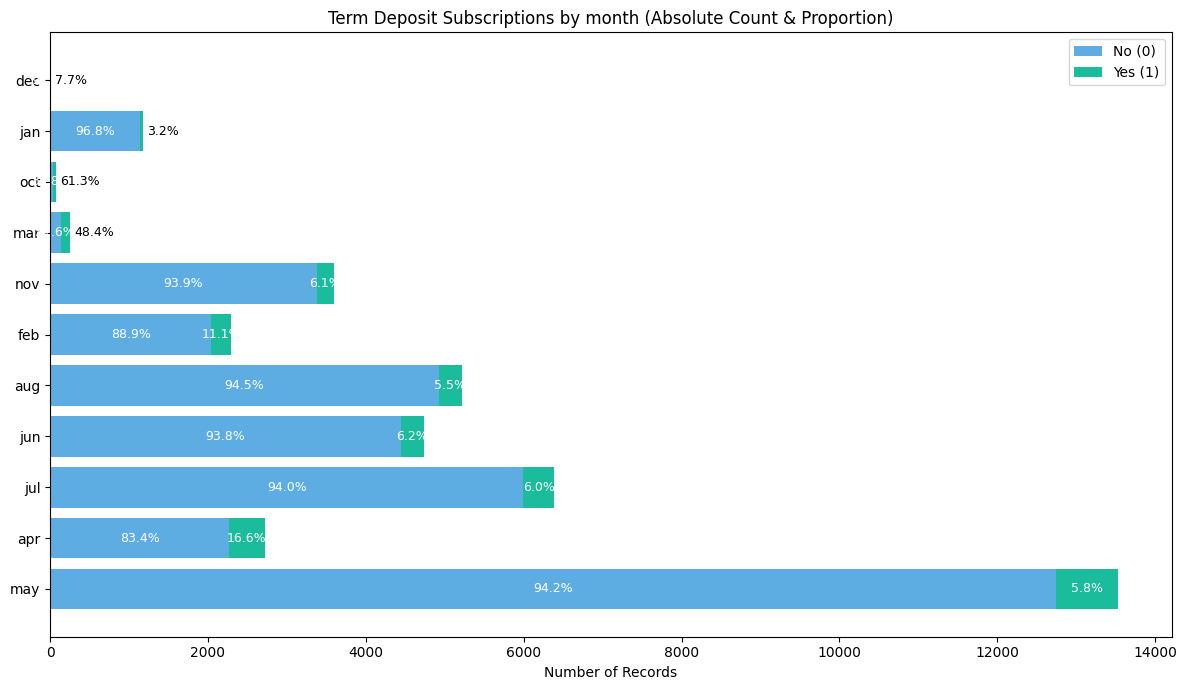

In [82]:
plot_TargetbyCat('month')

##### **#12 - duration**

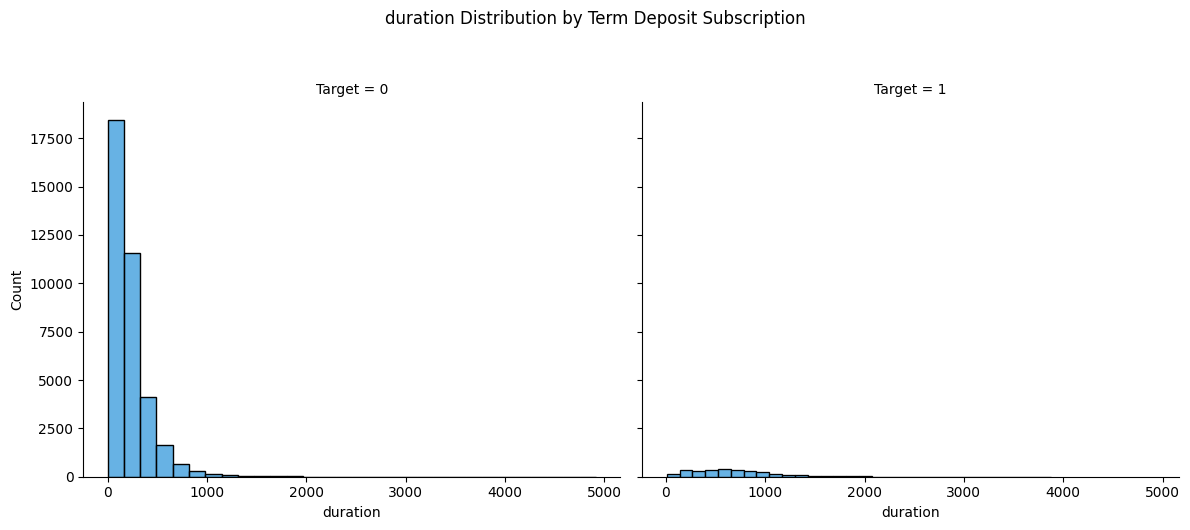

In [84]:
plot_facet_grid('duration')

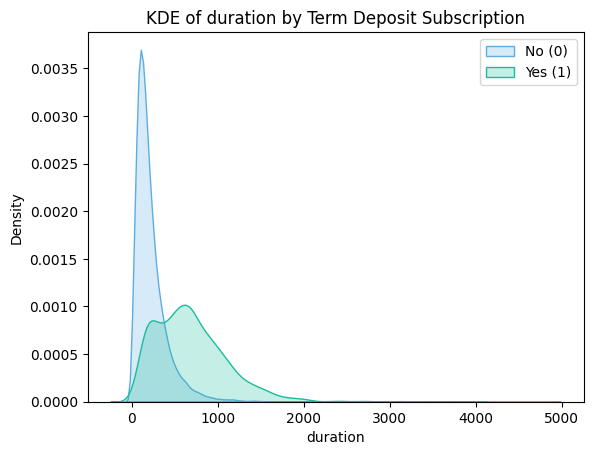

In [79]:
plot_KDE('duration')

##### **#13 - campaign**

Number of contact attempts made during the campaign


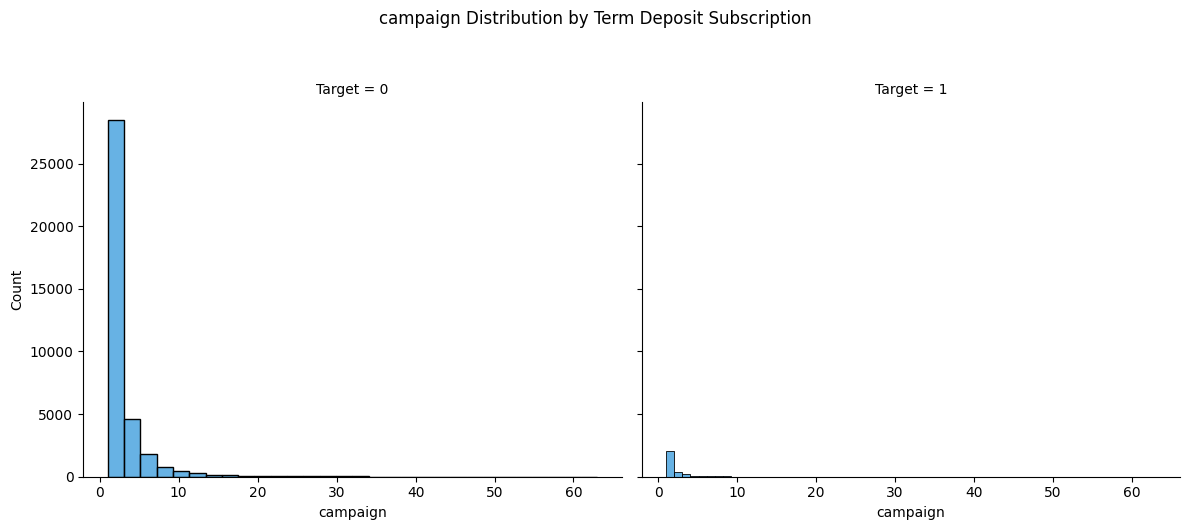

In [80]:
plot_facet_grid('campaign')

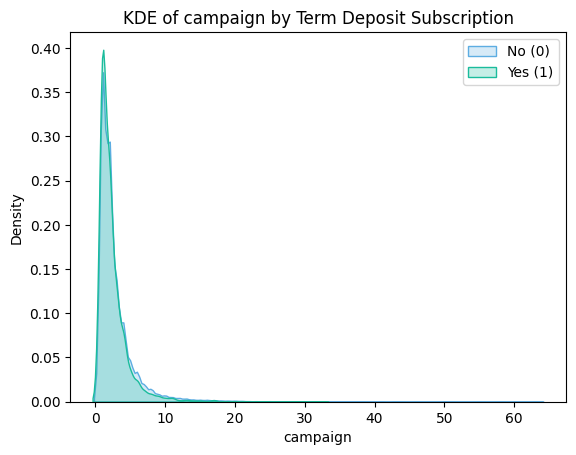

In [81]:
plot_KDE('campaign')

##### **month**

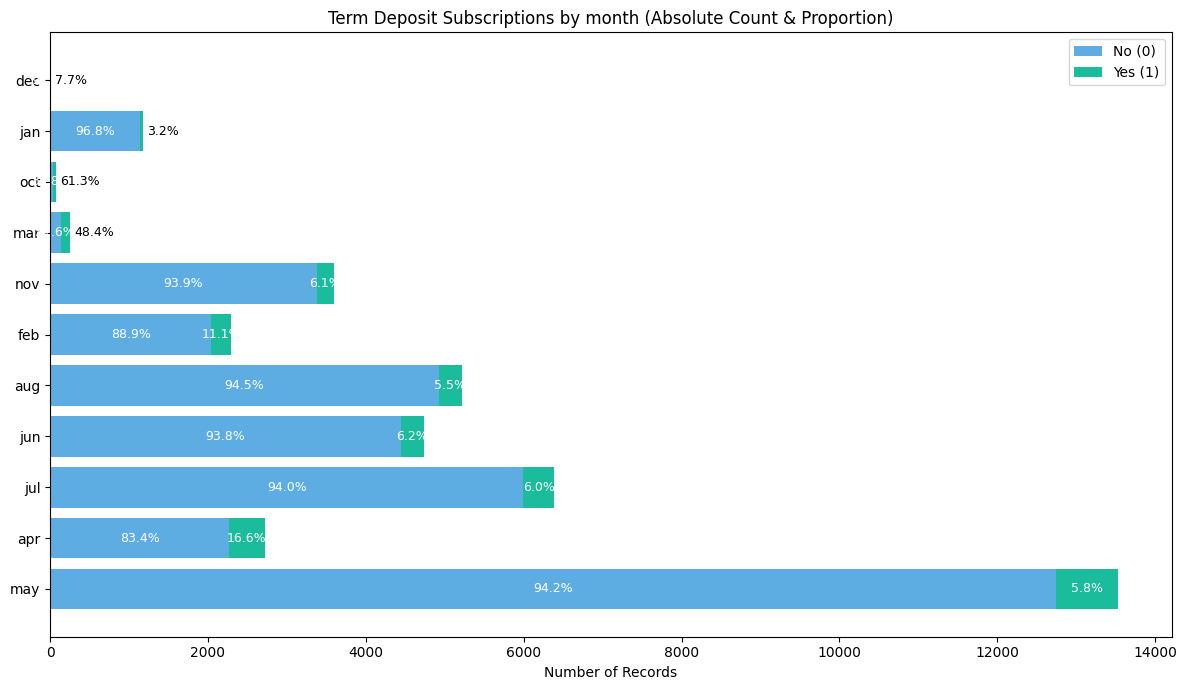

In [59]:
plot_TargetbyCat('month')

**Observation – March and October Outliers:**

The months of **March** and **October** exhibit an unusually high subscription rate compared to all other months. In March, nearly **48.4%** of contacts resulted in a term deposit subscription, and in October, the success rate was approximately **61.3%**. These values stand out significantly, especially when contrasted with the average success rate across the dataset (~7.2%).

While these high conversion rates may reflect specific marketing strategies or external factors, it's important to note that these months also have **very small sample sizes**, which may exaggerate their apparent effectiveness.

At this stage, no action is taken, but these anomalies should be kept in mind during modeling and evaluation.


##### **day**

In [60]:
pd.crosstab(df['day'], df['y'], normalize='index') 

y,0,1
day,,
1,0.772727,0.227273
2,0.906222,0.093778
3,0.908467,0.091533
4,0.901099,0.098901
5,0.933176,0.066824
6,0.938133,0.061867
7,0.950372,0.049628
8,0.937037,0.062963
9,0.947598,0.052402


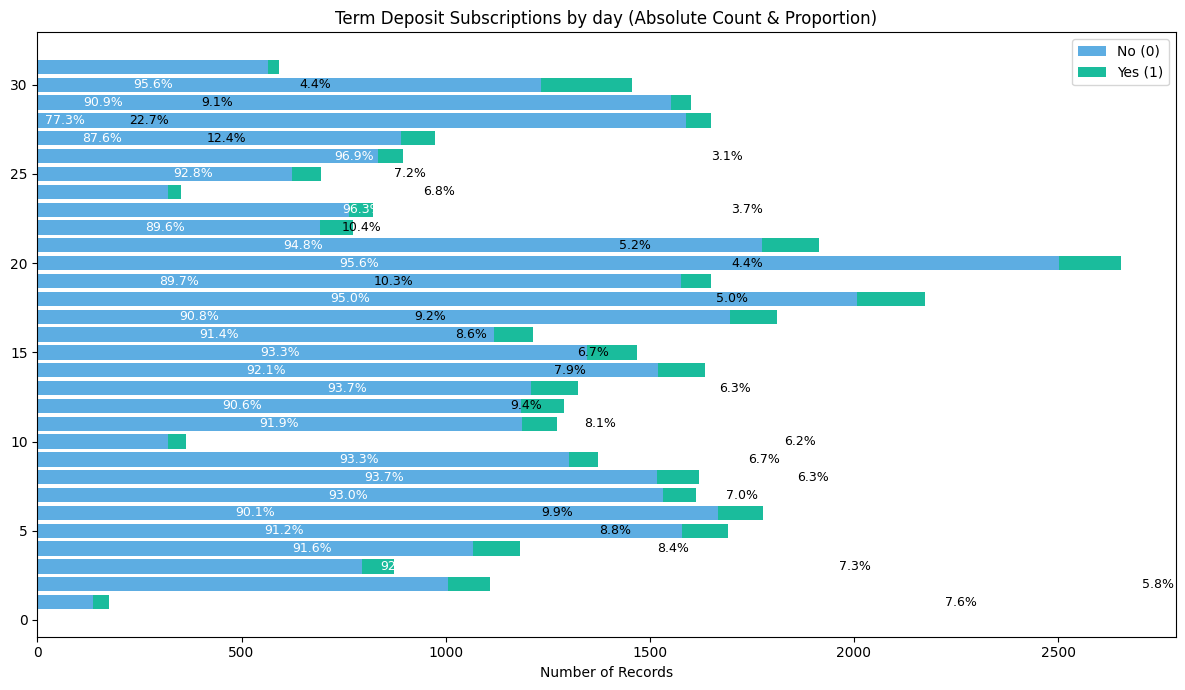

In [61]:
plot_TargetbyCat('day')

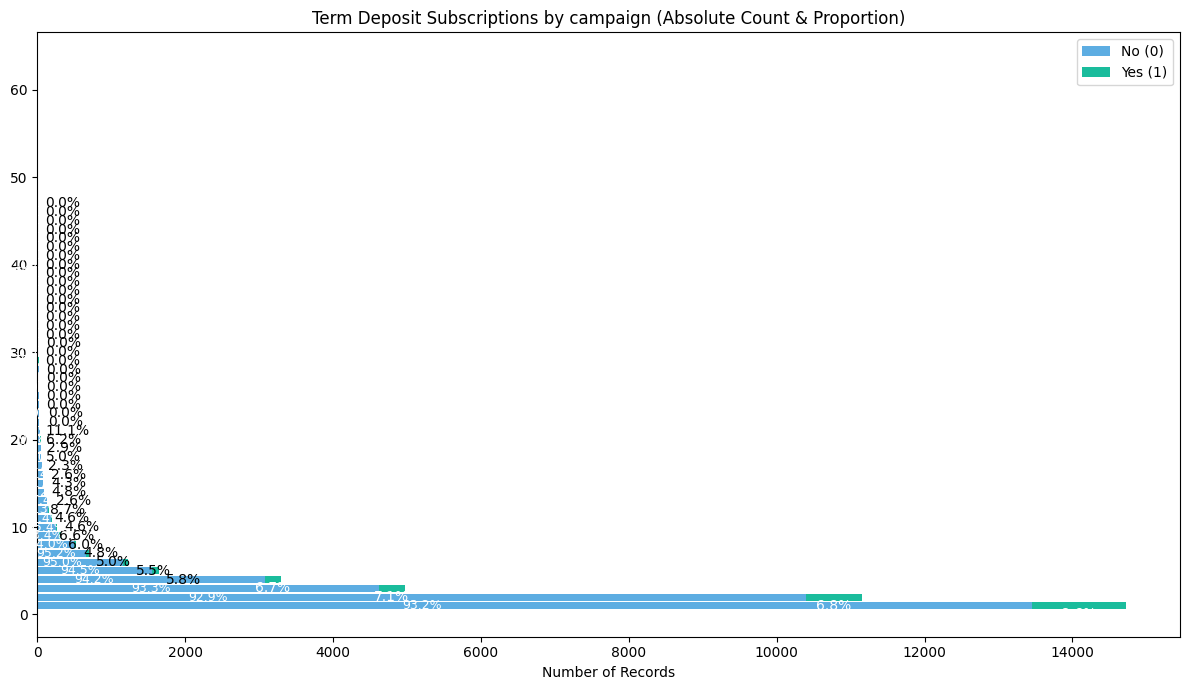

In [21]:
plot_TargetbyCat('campaign')

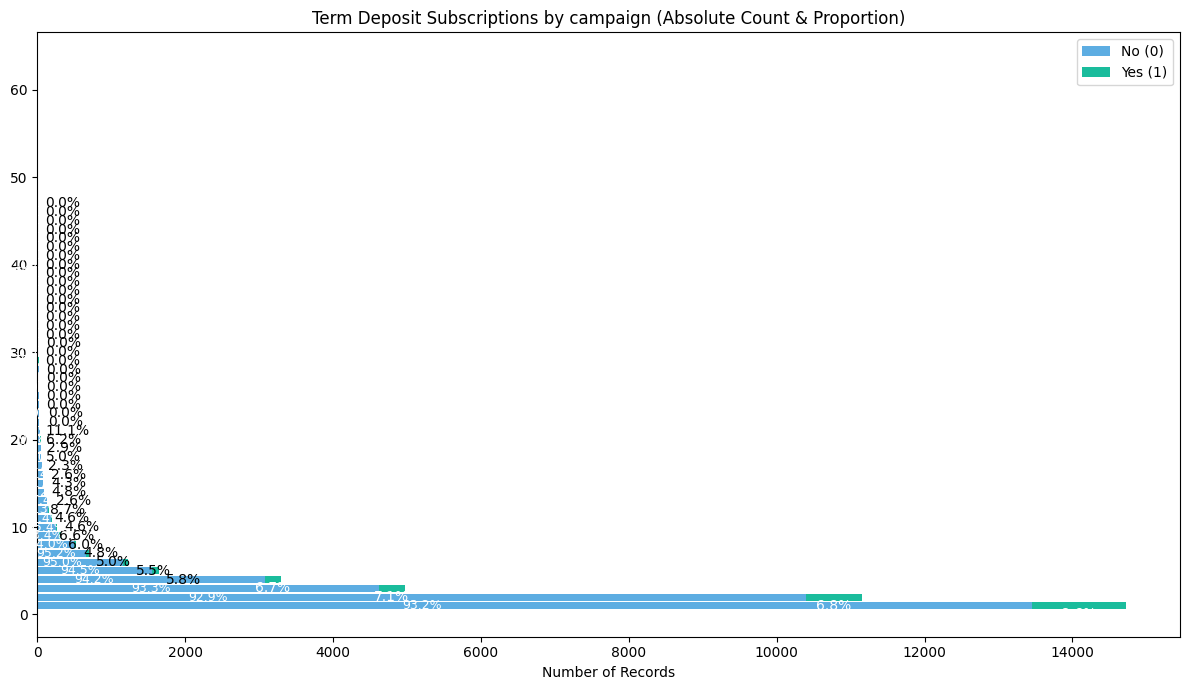

In [21]:
plot_TargetbyCat('campaign')

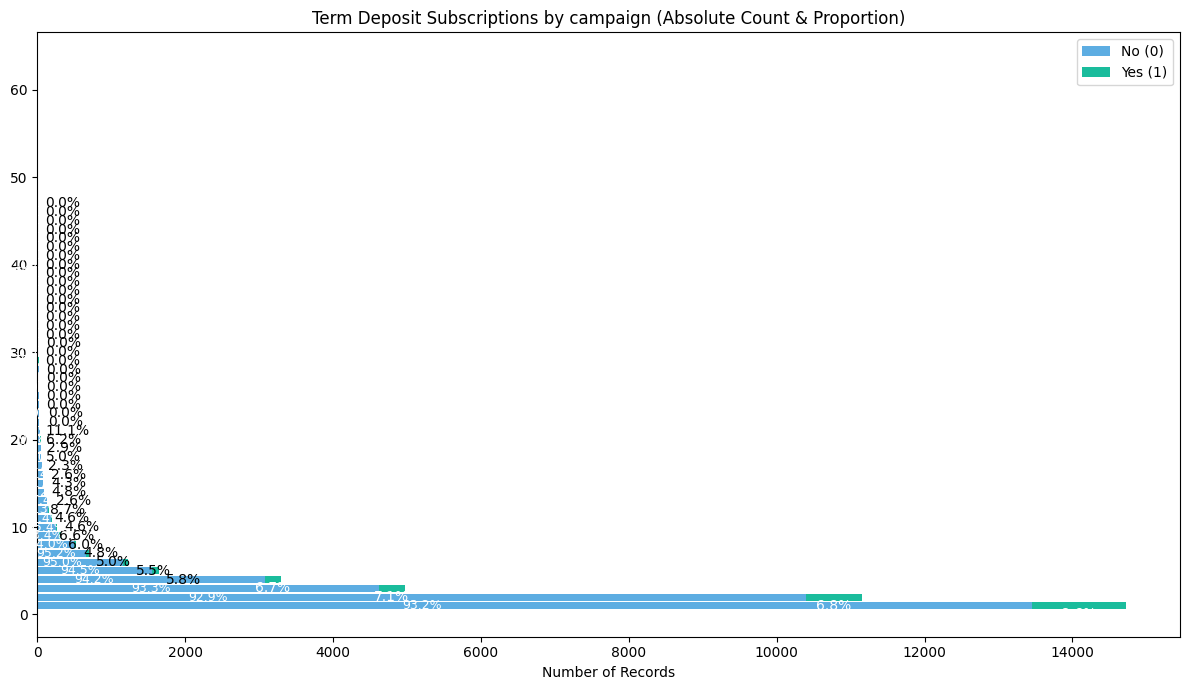

In [21]:
plot_TargetbyCat('campaign')

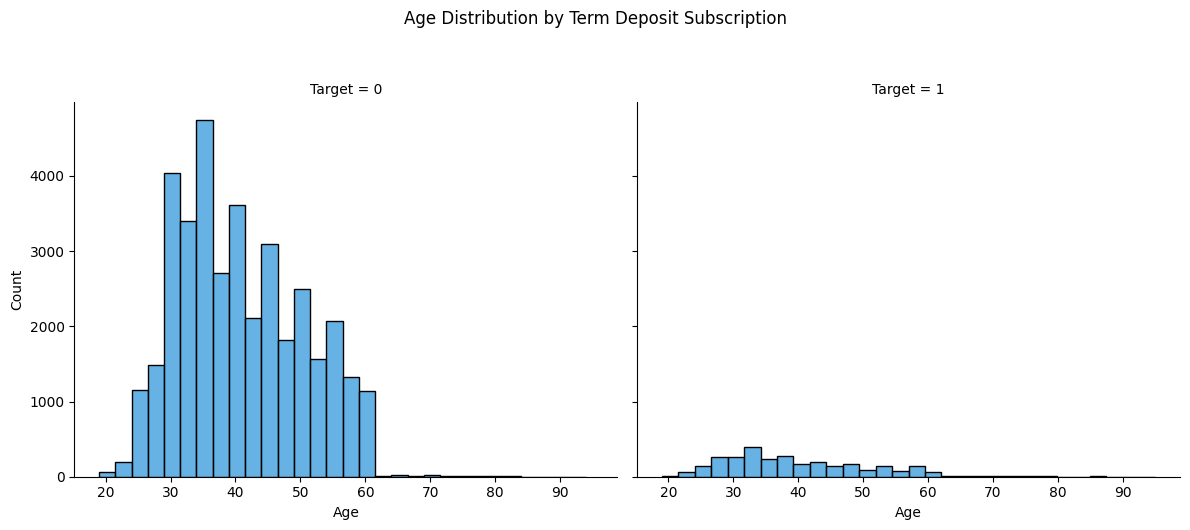

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(df, col='y', height=5, aspect=1.2)
g.map(sns.histplot, 'age', bins=30, color='#3498db', kde=False)
g.set_titles(col_template='Target = {col_name}')
g.set_axis_labels("Age", "Count")
g.fig.suptitle("Age Distribution by Term Deposit Subscription", y=1.05)
plt.tight_layout()
plt.show()


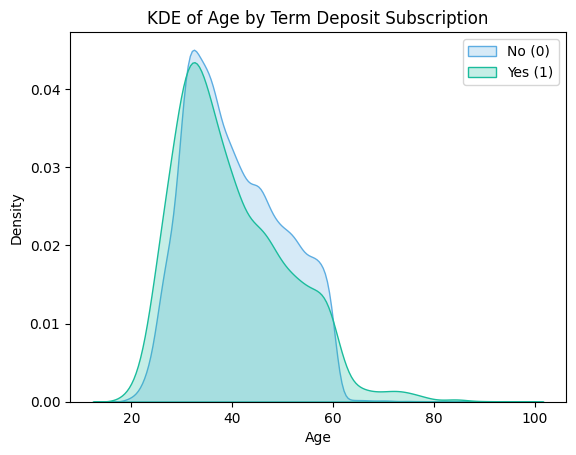

In [67]:
# KDE plot (no warning)
sns.kdeplot(data=df[df['y'] == 0], x='age', label='No (0)', fill=True, color='#5DADE2')
sns.kdeplot(data=df[df['y'] == 1], x='age', label='Yes (1)', fill=True, color='#1ABC9C')
plt.title("KDE of Age by Term Deposit Subscription")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.show()


In [25]:
df[df['y']=='yes'] 

age          37104
job          37104
marital      37104
education    37104
default      37104
balance      37104
housing      37104
loan         37104
contact      37104
day          37104
month        37104
duration     37104
campaign     37104
y            37104
dtype: int64

In [21]:
rows = df.shape[0]
print(f'Class\t\t\trows\t%\nPossitive(1 = Subscribed)  \t{df[df['y']==1].shape[0]} \t{(100*df[df['y']==1].shape[0]/rows):.1f}')
print(f'Negative(0 = Not Subscribed)\t{df[df['y']==0].shape[0]} \t{(100*df[df['y']==0].shape[0]/rows):.1f}')

Class			rows	%
Possitive(1 = Subscribed)  	0 	0.0
Negative(0 = Not Subscribed)	0 	0.0


#### Although the dataset is fairly balanced (54.8% happy vs. 45.2% unhappy), the proportion of unhappy customers is surprisingly high for a satisfaction survey. For a promising service, we would typically expect a significantly lower rate of dissatisfaction.


In [20]:
features = [ 'X' + str(i) for i in range(1,7,1)]


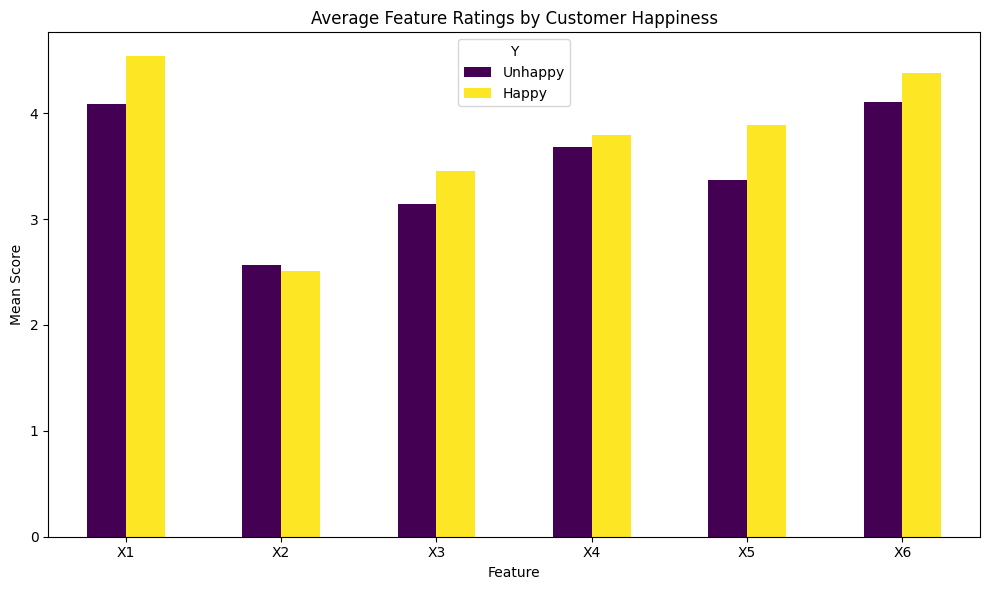

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

means = df.groupby('Y')[features].mean().T
means.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Average Feature Ratings by Customer Happiness')
plt.ylabel('Mean Score')
plt.xlabel('Feature')
plt.xticks(rotation=0)
plt.legend(title='Y', labels=['Unhappy', 'Happy'])
plt.tight_layout()
plt.show()

##### X1 = my order was delivered on time
##### X2 = contents of my order was as I expected
##### X3 = I ordered everything I wanted to order
##### X4 = I paid a good price for my order
##### X5 = I am satisfied with my courier
##### X6 = the app makes ordering easy for me

#### **Descriptive Statistics**

In [24]:
df.groupby('Y').mean()

,X1,X2,X3,X4,X5,X6
Y,,,,,,
0,4.087719,2.561404,3.140351,3.684211,3.368421,4.105263
1,4.536232,2.507246,3.449275,3.797101,3.884058,4.376812


In [25]:
df.groupby('Y').std()

,X1,X2,X3,X4,X5,X6
Y,,,,,,
0,0.851064,1.134170,1.007802,0.848484,1.189712,0.838455
1,0.698311,1.106441,1.022342,0.900649,1.064621,0.768908


#### **Boxplot and stripplot for each feature**

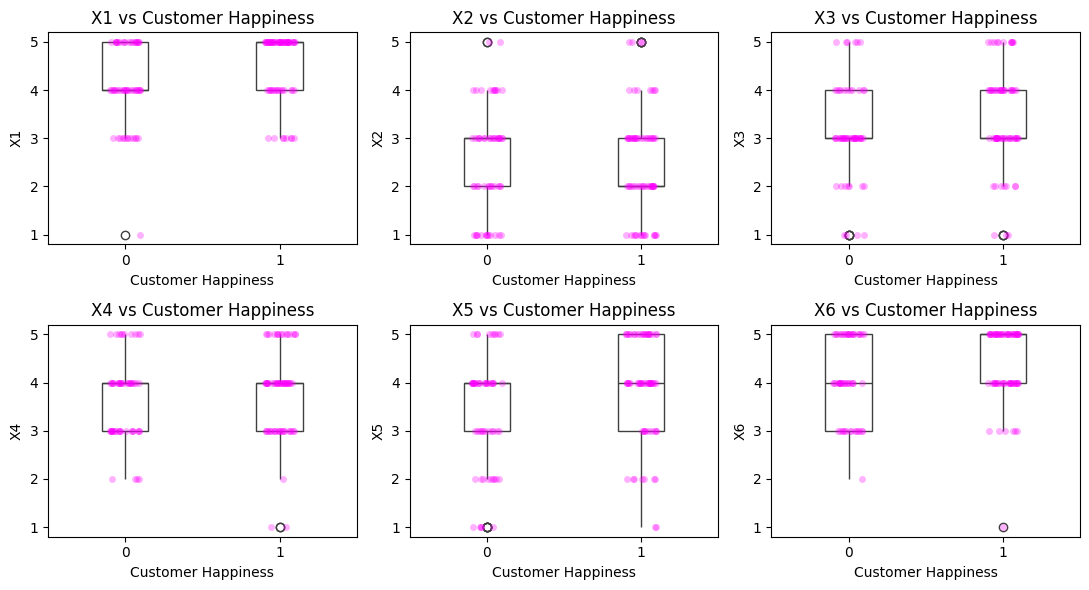

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(11, 6))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x='Y', y=col, data=df, ax=axes[i],
                width=0.3, showcaps=False,
                boxprops={'facecolor': 'None'})
    sns.stripplot(x='Y', y=col, data=df,
                  ax=axes[i], size=5, color='magenta', alpha=.3)
    axes[i].set_title(f'{col} vs Customer Happiness')
    axes[i].set_xlabel('Customer Happiness')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

#### **Histograms of each feature by Happy and Unhappy customers**

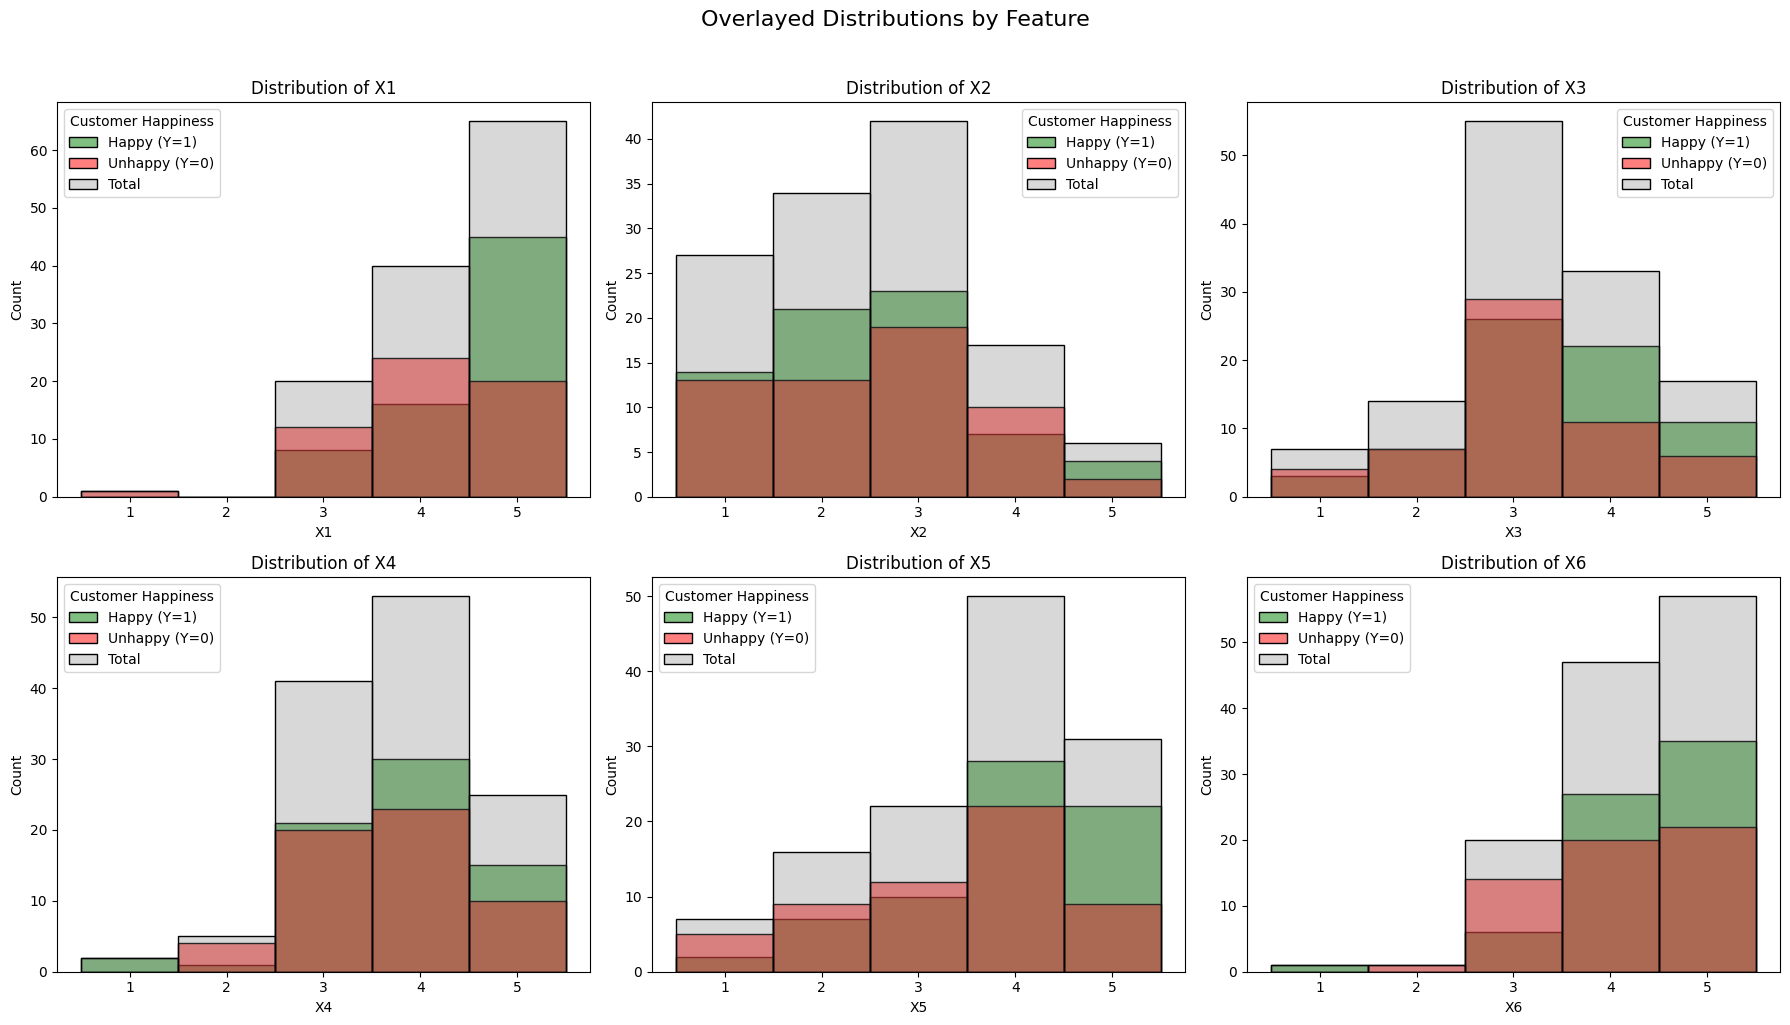

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(data=df, x=col, hue='Y', multiple='layer',
                 palette={0: 'red', 1: 'green'}, edgecolor='black',
                 stat='count', common_bins=True, bins=5, discrete=True, ax=axes[i])

    sns.histplot(data=df, x=col, color='gray', bins=5, discrete=True,
                 stat='count', edgecolor='black', label='Total', ax=axes[i], alpha=0.3)

    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend(title='Customer Happiness', labels=['Happy (Y=1)','Unhappy (Y=0)','Total'])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.suptitle("Overlayed Distributions by Feature", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### **Correlation Matrix of Features**

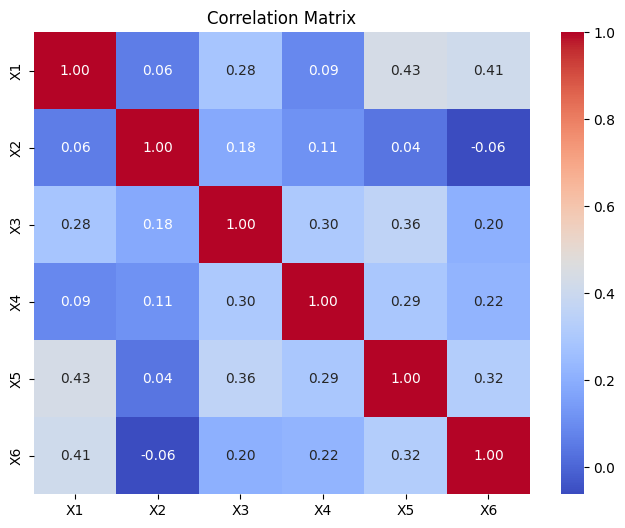

In [31]:
plt.figure(figsize=(8,6))
sns.heatmap(df.drop('Y', axis=1).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### **Ranking of categorical features from most to least informative with respect to the binary target (based on Mutual Information)**


In [33]:
from sklearn.feature_selection import mutual_info_classif

X = df[["X1", "X2", "X3", "X4", "X5", "X6"]]
y = df["Y"]

def mi_scores(X,y):
    
    # Apply MI
    mi_scores = mutual_info_classif(X, y, discrete_features=True, random_state=23)
    
    # Wrap in a DataFrame for readability
    mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
    mi_df = mi_df.sort_values(by='MI Score', ascending=False)
    
    print(mi_df)

    mi_df.plot(kind='bar', x='Feature', y='MI Score', legend=False, title='Mutual Information with Target')
    plt.ylabel('MI Score')
    plt.tight_layout()
    plt.show()

  Feature  MI Score
0      X1  0.049705
5      X6  0.035543
4      X5  0.027627
3      X4  0.021880
2      X3  0.017432
1      X2  0.009468


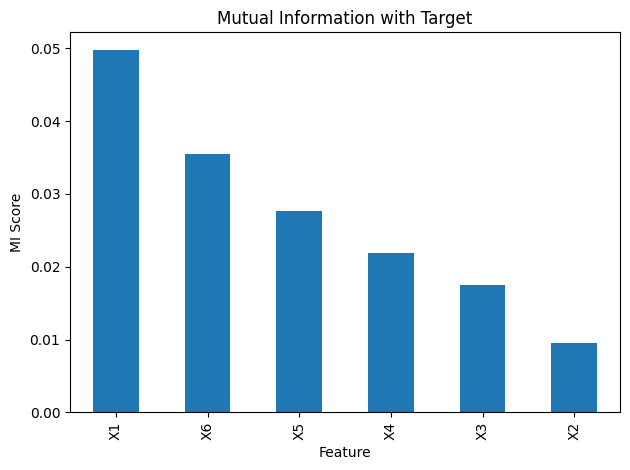

In [34]:
mi_scores(X,y)


#### **Ranking of categorical features using chi-square score by feature**


In [36]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder

def chi_score(X,y):
    # Compute Chi2 scores
    chi_scores, p_values = chi2(X, y)
    
    chi2_results = pd.DataFrame({
        'Feature': X.columns,
        'Chi2 Score': chi_scores,
        'p-value': p_values
    }).sort_values(by='Chi2 Score', ascending=False)
    
    print(chi2_results)

    plt.figure(figsize=(8, 5))
    plt.bar(chi2_results['Feature'], chi2_results['Chi2 Score'], color='green')
    plt.title('Chi-Square Scores by Feature')
    plt.xlabel('Feature')
    plt.ylabel('Chi2 Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


  Feature  Chi2 Score   p-value
4      X5    2.273286  0.131621
0      X1    1.449041  0.228682
2      X3    0.900104  0.342754
5      X6    0.541070  0.461989
3      X4    0.106194  0.744520
1      X2    0.036161  0.849183


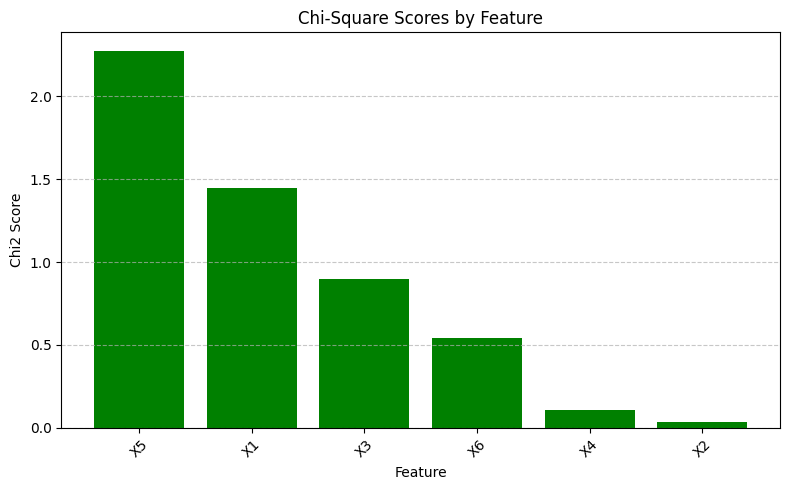

In [37]:
chi_score(X,y)

The higher the chi-square score, the more predictive or informative that feature is about the customer's happiness.

### Feature Importance (Mutual Information and Chi-Square)

| Feature | MI Score | Chi² Score | Interpretation                                    |
|--------:|---------:|-----------:|--------------------------------------------------:|
| **X1**  | 0.0497   | 1.4490     | Top feature by MI, moderately associated by Chi²  |
| **X6**  | 0.0355   | 0.5411     | Second-best in MI, weak Chi² association          |
| **X5**  | 0.0276   | 2.2733     | High in both scores, borderline significant       |
| **X4**  | 0.0219   | 0.1062     | Low impact in both MI and Chi²                    |
| **X3**  | 0.0174   | 0.9001     | Mild in both, not significant                     |
| **X2**  | 0.0095   | 0.0362     | Least informative in both metrics                 |


----

<a id="model-training"></a>
### 2 - Experimenting with Prediction Models


In [42]:
import random

In [43]:
#seed = random.randint(1000,9999)
seed = 23
#seed

In [44]:
from sklearn.model_selection import train_test_split
 
X = df[features]
y = df['Y']
# Split the sets using stratify because of the class imbalance.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed) 

In [45]:
print(f'Class balance after split: \nSet\tPossitive\tNegattive\nTrain \t{(100*y_train[y_train == 1].shape[0] / y_train.shape[0]):.1f} %\t\t {(100*y_train[y_train == 0].shape[0] / y_train.shape[0]):.1f}%')
print(f'Test \t{(100*y_test[y_test == 1].shape[0] / y_test.shape[0]):.1f} %\t\t {(100*y_test[y_test == 0].shape[0] / y_test.shape[0]):.1f}%')

Class balance after split: 
Set	Possitive	Negattive
Train 	55.0 %		 45.0%
Test 	53.8 %		 46.2%


In [46]:
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgb
import os
import sys
import contextlib


In [47]:
# Helper function to suppress all stdout and stderr output,
# avoiding verbose LightGBM info/warning messages during model training.
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        with contextlib.redirect_stdout(devnull), contextlib.redirect_stderr(devnull):
            yield


In [48]:
with suppress_output():
    clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None, random_state=seed)
    models_baseline = clf.fit(X_train, X_test, y_train, y_test)[0]
models_baseline


  0%|          | 0/31 [00:00<?, ?it/s]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LabelSpreading,0.62,0.62,0.62,0.62,0.01
NuSVC,0.58,0.60,0.60,0.55,0.01
Perceptron,0.58,0.59,0.59,0.57,0.01
LabelPropagation,0.58,0.58,0.58,0.58,0.01
RandomForestClassifier,0.54,0.55,0.55,0.52,0.11
ExtraTreeClassifier,0.54,0.55,0.55,0.52,0.01
LGBMClassifier,0.54,0.55,0.55,0.52,0.20
ExtraTreesClassifier,0.54,0.55,0.55,0.53,0.08
DecisionTreeClassifier,0.54,0.55,0.55,0.53,0.01


### General observation: 
The target accuracy of 73% is significantly higher than the results obtained using popular classification models (ranging from 35% to 62%). To close this gap, we will experiment with feature engineering techniques.


---

<a id="feature-engineering"></a>
### 3- Feature Engineering

#### 3.1- Combine X1, X5 and X6 (strongest contributor features)

In [53]:
df['X_1_5_6_weighted'] = (0.5 * df['X1'] + 0.3 * df['X5'] + 0.2 * df['X6'])

In [54]:
features += ['X_1_5_6_weighted']
X = df[features]
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed) 

In [55]:
with suppress_output():
    models_after_featEng_1 = clf.fit(X_train, X_test, y_train, y_test)[0]


  0%|          | 0/31 [00:00<?, ?it/s]

In [56]:
models_baseline.rename(columns={'Accuracy': 'Accuracy_BL'}, inplace=True)

In [57]:
comparison_df = models_baseline[['Accuracy_BL']].join(
    models_after_featEng_1[['Accuracy']], rsuffix='_FE_1'
)

comparison_df.rename(columns={'Accuracy': 'Accuracy_FE_1'}, inplace=True)
comparison_df['Delta_Accuracy_FE_1'] = (
    comparison_df['Accuracy_FE_1'] - comparison_df['Accuracy_BL']
)
comparison_df.sort_values(by='Accuracy_BL', ascending=False)

,Accuracy_BL,Accuracy_FE_1,Delta_Accuracy_FE_1
Model,,,
LabelSpreading,0.62,0.62,0.00
NuSVC,0.58,0.54,-0.04
Perceptron,0.58,0.46,-0.12
LabelPropagation,0.58,0.58,0.00
RandomForestClassifier,0.54,0.54,0.00
ExtraTreeClassifier,0.54,0.54,0.00
LGBMClassifier,0.54,0.46,-0.08
ExtraTreesClassifier,0.54,0.54,0.00
DecisionTreeClassifier,0.54,0.50,-0.04


In [58]:
print(f'Features included in Feature Eng. Step 1: \n{features}')
print(f"Average Models' Accuracy Gain after Feature Engineering Step 1: {100*(comparison_df['Delta_Accuracy_FE_1'].sum()/comparison_df.shape[0]):.2f}%")

Features included in Feature Eng. Step 1: 
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X_1_5_6_weighted']
Average Models' Accuracy Gain after Feature Engineering Step 1: -0.14%


#### 3.2- Add Binary Flags: Extremely Good or Bad Scores

In [60]:
for col in ['X1', 'X5', 'X6']:
    df[f'{col}_is_5'] = (df[col] == 5).astype(int)
    df[f'{col}_is_1'] = (df[col] == 1).astype(int)

In [61]:
features += ['X1_is_5', 'X1_is_1', 'X5_is_5', 'X5_is_1', 'X6_is_5', 'X6_is_1']
X = df[features]
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed) 

In [62]:
with suppress_output():
    models_after_featEng_2 = clf.fit(X_train, X_test, y_train, y_test)[0]

  0%|          | 0/31 [00:00<?, ?it/s]

In [63]:
comparison_df = models_baseline[['Accuracy_BL']].join(
    models_after_featEng_2[['Accuracy']], rsuffix='_FE_2'
)


In [64]:
comparison_df.rename(columns={'Accuracy': 'Accuracy_FE_1+2'}, inplace=True)
comparison_df['Delta_Accuracy_FE_1+2'] = (
    comparison_df['Accuracy_FE_1+2'] - comparison_df['Accuracy_BL']
)
comparison_df.sort_values(by='Accuracy_BL', ascending=False)

,Accuracy_BL,Accuracy_FE_1+2,Delta_Accuracy_FE_1+2
Model,,,
LabelSpreading,0.62,0.62,0.00
NuSVC,0.58,0.62,0.04
Perceptron,0.58,0.50,-0.08
LabelPropagation,0.58,0.62,0.04
RandomForestClassifier,0.54,0.62,0.08
ExtraTreeClassifier,0.54,0.54,0.00
LGBMClassifier,0.54,0.46,-0.08
ExtraTreesClassifier,0.54,0.58,0.04
DecisionTreeClassifier,0.54,0.46,-0.08


In [65]:
print(f'Features included in Feature Eng. Step 2: \n{features}')
print(f"Average Models' Accuracy Gain after Feature Engineering Step 2: {100*(comparison_df['Delta_Accuracy_FE_1+2'].sum()/comparison_df.shape[0]):.2f}%")


Features included in Feature Eng. Step 2: 
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X1_is_1', 'X5_is_5', 'X5_is_1', 'X6_is_5', 'X6_is_1']
Average Models' Accuracy Gain after Feature Engineering Step 2: 3.42%


#### 3.3- Add Binary flags for X2 and X4

In [67]:
df['X2_disappointed'] = (df['X2'] < 3).astype(int)
df['X4_bad_price'] = (df['X4'] <= 2).astype(int)

In [68]:
features += ['X2_disappointed', 'X4_bad_price']

In [69]:
X = df[features]
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed) 

In [70]:
with suppress_output():
    models_after_featEng_3 = clf.fit(X_train, X_test, y_train, y_test)[0]

  0%|          | 0/31 [00:00<?, ?it/s]

In [71]:
comparison_df = models_baseline[['Accuracy_BL']].join(
    models_after_featEng_3[['Accuracy']], rsuffix='_FE_1+2+3'
)
comparison_df.rename(columns={'Accuracy': 'Accuracy_FE_1+2+3'}, inplace=True)
comparison_df['Delta_Accuracy_FE_1+2+3'] = (
    comparison_df['Accuracy_FE_1+2+3'] - comparison_df['Accuracy_BL']
)
comparison_df.sort_values(by='Accuracy_BL', ascending=False)

,Accuracy_BL,Accuracy_FE_1+2+3,Delta_Accuracy_FE_1+2+3
Model,,,
LabelSpreading,0.62,0.62,0.00
NuSVC,0.58,0.54,-0.04
Perceptron,0.58,0.54,-0.04
LabelPropagation,0.58,0.62,0.04
RandomForestClassifier,0.54,0.62,0.08
ExtraTreeClassifier,0.54,0.62,0.08
LGBMClassifier,0.54,0.46,-0.08
ExtraTreesClassifier,0.54,0.65,0.12
DecisionTreeClassifier,0.54,0.50,-0.04


In [72]:
print(f'Features included in Feature Eng. Step 3: \n{features}')
print(f"Average Models' Accuracy Gain after Feature Engineering Step 3: {100*(comparison_df['Delta_Accuracy_FE_1+2+3'].sum()/comparison_df.shape[0]):.2f}%")

Features included in Feature Eng. Step 3: 
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X1_is_1', 'X5_is_5', 'X5_is_1', 'X6_is_5', 'X6_is_1', 'X2_disappointed', 'X4_bad_price']
Average Models' Accuracy Gain after Feature Engineering Step 3: 3.99%


#### 3.4- Plot the Partial Dependence of Selected Features on Prediction

In [74]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [75]:
model_RF = RandomForestClassifier(random_state=seed)  # We selected the Random Forest Model to plot the Dependence of Selected Features
model_RF.fit(X_train, y_train)

result = permutation_importance(model_RF, X_test, y_test, n_repeats=30, random_state=seed)


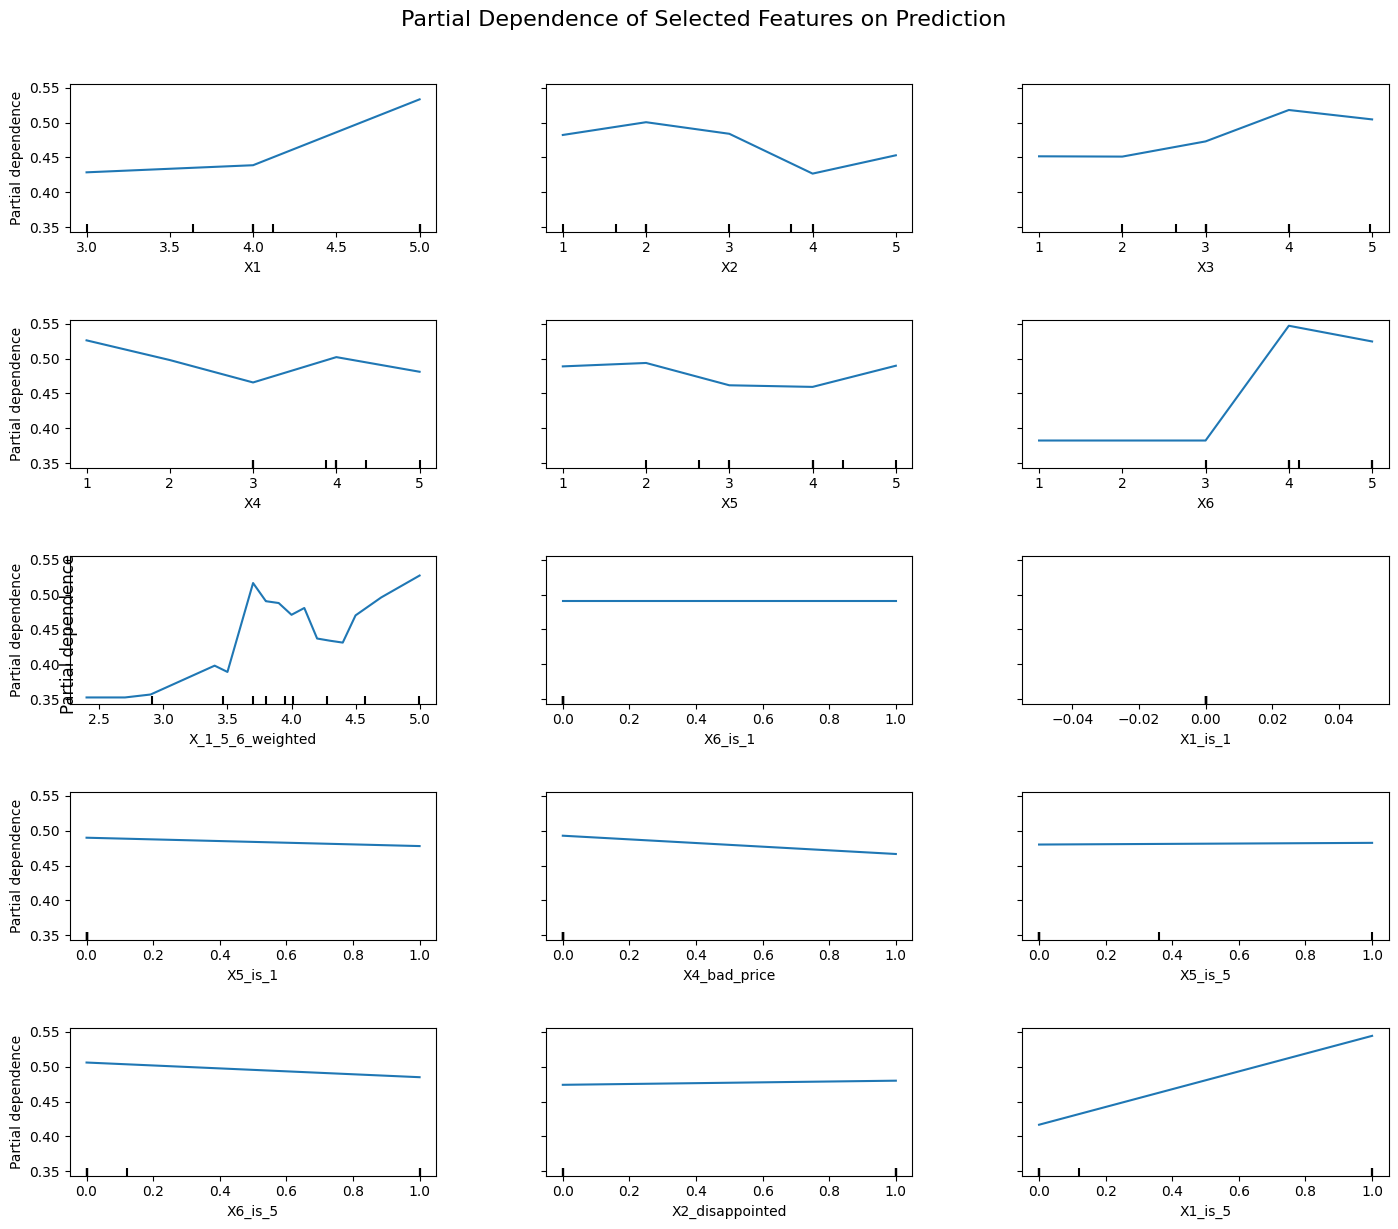

In [76]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6',
                    'X_1_5_6_weighted', 'X6_is_1', 'X1_is_1',
                    'X5_is_1', 'X4_bad_price', 'X5_is_5',
                    'X6_is_5', 'X2_disappointed', 'X1_is_5']

fig, ax = plt.subplots(figsize=(14, 12))  # increase total figure size

pdp_display = PartialDependenceDisplay.from_estimator(
    model_RF, X_test, features=features_to_plot,
    kind='average', grid_resolution=20, ax=ax
)

# Update spacing between subplots
plt.subplots_adjust(hspace=0.6, wspace=0.3)  # hspace controls row spacing

# Set one y-axis label
fig.text(0.04, 0.5, 'Partial dependence', va='center', rotation='vertical', fontsize=12)

plt.suptitle("Partial Dependence of Selected Features on Prediction", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


#### Some features show clear trends. Others are flat → meaning they contribute almost nothing to prediction.
#### Then, I will perform the following feature selection:
Keep (clear upward, steep jumps or negative slope):
* X1_is_5,
* X_1_5_6_weighted,
* X6_is_5,
* X1,
* X3,
    
Remove (flat or very noisy):
* X1_is_1,
* X5_is_1,
* X6_is_1,
* X5_is_5,
* X2_disappointed,
* X4_bad_price



----

<a id="feature-selection"></a>
### 4- Feature Selection

In [79]:
print(features)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X1_is_1', 'X5_is_5', 'X5_is_1', 'X6_is_5', 'X6_is_1', 'X2_disappointed', 'X4_bad_price']


In [80]:
features_to_remove= ['X1_is_1', 'X5_is_5', 'X5_is_1', 'X6_is_1', 'X2_disappointed', 'X4_bad_price']
for feature in features_to_remove: 
    features.remove(feature)


In [81]:
print(features)

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X6_is_5']


In [82]:
X = df[features]
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed) 

In [83]:
with suppress_output():
    models_after_featEng_4 = clf.fit(X_train, X_test, y_train, y_test)[0]

  0%|          | 0/31 [00:00<?, ?it/s]

In [84]:
comparison_df = models_baseline[['Accuracy_BL']].join(
    models_after_featEng_4[['Accuracy']], rsuffix='_FE_1+2+3+4'
)
comparison_df.rename(columns={'Accuracy': 'Accuracy_FE_1+2+3+4'}, inplace=True)
comparison_df['Delta_Accuracy_FE_1+2+3+4'] = (
    comparison_df['Accuracy_FE_1+2+3+4'] - comparison_df['Accuracy_BL']
)
comparison_df.sort_values(by='Accuracy_BL', ascending=False)

,Accuracy_BL,Accuracy_FE_1+2+3+4,Delta_Accuracy_FE_1+2+3+4
Model,,,
LabelSpreading,0.62,0.62,0.00
NuSVC,0.58,0.54,-0.04
Perceptron,0.58,0.46,-0.12
LabelPropagation,0.58,0.58,0.00
RandomForestClassifier,0.54,0.62,0.08
ExtraTreeClassifier,0.54,0.62,0.08
LGBMClassifier,0.54,0.46,-0.08
ExtraTreesClassifier,0.54,0.58,0.04
DecisionTreeClassifier,0.54,0.50,-0.04


In [85]:
print(f'Features included in Feature Eng. Step 4: \n{features}')
print(f"Average Models' Accuracy Gain after Feature Engineering Step 4: {100*(comparison_df['Delta_Accuracy_FE_1+2+3+4'].sum()/comparison_df.shape[0]):.2f}%")

Features included in Feature Eng. Step 4: 
['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X6_is_5']
Average Models' Accuracy Gain after Feature Engineering Step 4: 2.85%


### Feature Selection:

| Feature                            | Type                 | Likely Impact                               |
|------------------------------------|----------------------|---------------------------------------------|
| `X1`, `X2`, `X3`, `X4`, `X5`, `X6` | Categorical (0–5)    | Core question responses                     |
| `X_1_5_6_weighted`                 | Numeric (engineered) | Weighted aggregation of important features  |
| `X1_is_5`, `X6_is_5`               | Binary flags         | High-satisfaction indicators                |



----

<a id="hyperopt"></a>
### 5- Optimize the model and hyperparameters



In this section, we will explore the benefits of applying hyperparameter optimization to improve model performance. We’ll focus on the Random Forest model as our candidate for tuning.


#### 5.1- RandomizedSearch

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report


In [93]:
# Define the model
model = RandomForestClassifier(random_state=seed)


In [94]:
# Define the parameter grid
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(2, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}


In [95]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=40,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=seed,
    verbose=2
)



In [96]:
# Fit the model
random_search.fit(X_train, y_train)



Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=23),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C3F9FFACC0>,
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C3F99313A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C3F97F9E20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002C3F97E5670>},
                   random_state=23, scoring='accuracy', verbose=2)

In [97]:
# Evaluate
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Params:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Best Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 85}
Accuracy: 0.5384615384615384

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.67      0.57        12
           1       0.60      0.43      0.50        14

    accuracy                           0.54        26
   macro avg       0.55      0.55      0.54        26
weighted avg       0.55      0.54      0.53        26



#### 5.2- GridSearch

In [99]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=23),
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=RandomForestClassifier(random_state=23), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'max_features': ['sqrt', None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [100]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Best Params:", grid_search.best_params_)


Accuracy: 0.5384615384615384
              precision    recall  f1-score   support

           0       0.50      0.75      0.60        12
           1       0.62      0.36      0.45        14

    accuracy                           0.54        26
   macro avg       0.56      0.55      0.53        26
weighted avg       0.57      0.54      0.52        26

Best Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


#### Finally, neither Random Search nor Grid Search yielded a better-performing Random Forest model for the selected features, with the highest accuracy remaining at 62%.

----

<a id="additional-feature-engineering"></a>
### 6- Additional Feature Engineering steps

Let's add 3 more features

In [105]:
feature_cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

df['X5_minus_X6'] = df['X5'] - df['X6']
df['X_avg_all'] = df[feature_cols].mean(axis=1)
df['num_fives'] = df[feature_cols].apply(lambda row: (row == 5).sum(), axis=1)

In [106]:
features += ['X5_minus_X6', 'X_avg_all', 'num_fives']
X = df[features]
y = df['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23) 

             Feature  MI Score
6   X_1_5_6_weighted      0.21
10         X_avg_all      0.10
0                 X1      0.05
7            X1_is_5      0.05
5                 X6      0.04
9        X5_minus_X6      0.04
11         num_fives      0.04
4                 X5      0.03
3                 X4      0.02
2                 X3      0.02
1                 X2      0.01
8            X6_is_5      0.01


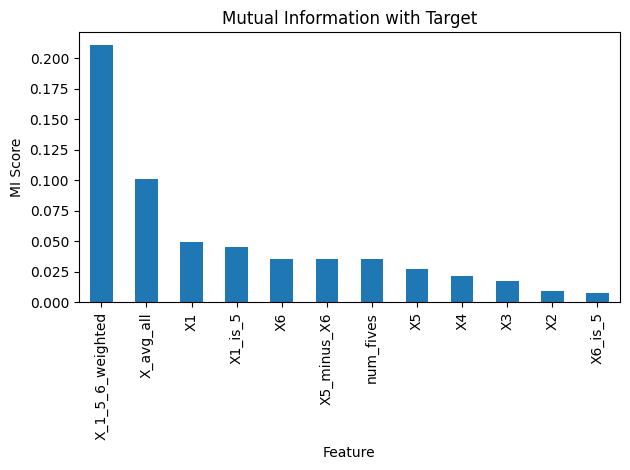

In [107]:
mi_scores(X,y)

             Feature  Chi2 Score  p-value
10         num_fives        9.66     0.00
7            X1_is_5        5.49     0.02
4                 X5        2.27     0.13
0                 X1        1.45     0.23
6   X_1_5_6_weighted        1.42     0.23
8            X6_is_5        1.01     0.31
2                 X3        0.90     0.34
9          X_avg_all        0.61     0.43
5                 X6        0.54     0.46
3                 X4        0.11     0.74
1                 X2        0.04     0.85


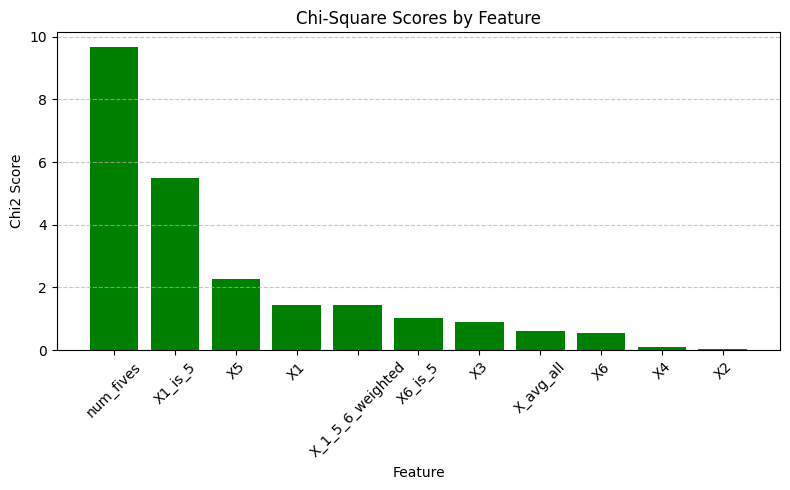

In [108]:
chi_score(X.drop('X5_minus_X6', axis=1),y)

#### Acording with the results (MI and Chi^2 Scores), `num_fives` and `X_avg_all` seem promising! 

----

<a id="exploring-features-and-models-combinations"></a>
### 7- Exploring Features and Models Combinations

We will experiment with the **best 6 performing models** with all possible **feature subsets ranging from 4 to 10 features**, using the 12 previously selected variables.
Given the small size of the dataset, the computational time required for this brute-force approach would be acceptable.


In [112]:
from itertools import combinations
from tqdm import tqdm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.svm import NuSVC

In [113]:
global_feature_selection = [
    'X1','X2', 'X4', 'X3', 'X5', 'X6', 'X_1_5_6_weighted',
    'X1_is_5', 'X6_is_5', 'X5_minus_X6', 'X_avg_all', 'num_fives',
]

top_models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=seed),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=seed),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=seed),
    'LabelSpreading': LabelSpreading(),
    'LabelPropagation': LabelPropagation(),
    'NuSVC': NuSVC()
}

results = []

# Total number of combinations to evaluate
total_combos = sum(len(list(combinations(global_feature_selection, r))) for r in range(4, len(global_feature_selection) + 1))

with tqdm(total=total_combos, desc="Evaluating combinations") as pbar:
    for r in range(4, len(global_feature_selection) + 1):
        for combo in combinations(global_feature_selection, r):
            selected_features = list(combo)
            X = df[selected_features]
            y = df['Y']

            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, stratify=y, random_state=seed
            )

            for model_name, model in top_models.items():
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                acc = round(accuracy_score(y_test, y_pred), 6)
                results.append({'Model': model_name, 'Features': selected_features, 'Accuracy': acc})
            pbar.update(1)

pd.set_option('display.float_format', '{:.3f}'.format)
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)




Evaluating combinations: 100%|█████████████████████████████████████████████████████| 3797/3797 [13:03<00:00,  4.85it/s]


In [114]:
results_df.head(20)

,Model,Features,Accuracy
0,ExtraTreeClassifier,"[X1, X2, X4, X_1_5_6_weighted, X5_minus_X6, X_...",0.808
1,NuSVC,"[X4, X_1_5_6_weighted, X6_is_5, X_avg_all]",0.808
2,NuSVC,"[X4, X_1_5_6_weighted, X1_is_5, X6_is_5, X_avg...",0.769
3,NuSVC,"[X4, X_1_5_6_weighted, X6_is_5, X_avg_all, num...",0.769
4,LabelSpreading,"[X1, X2, X4, X5, X6, X1_is_5, X_avg_all, num_f...",0.769
5,ExtraTreesClassifier,"[X1, X3, X6, X1_is_5, X6_is_5, num_fives]",0.769
6,NuSVC,"[X6, X1_is_5, X6_is_5, X_avg_all, num_fives]",0.769
7,LabelSpreading,"[X1, X2, X4, X5, X6, X_1_5_6_weighted, X6_is_5...",0.769
8,LabelSpreading,"[X1, X2, X4, X5, X6, X1_is_5, X6_is_5, X_avg_a...",0.769
9,RandomForestClassifier,"[X1, X5, X1_is_5, X6_is_5, X_avg_all]",0.769


After conducting feature engineering and testing multiple models using a fixed train/test split (with random_state=23), we identified a set of top-performing model–feature combinations that exceeded our target accuracy of 73%. The best-performing configurations achieved an accuracy of 80.8%, correctly predicting 21 out of 26 rows in the test set. These combinations involved models such as NuSVC, RandomForestClassifier, ExtraTreesClassifier, LabelSpreading and LabelPropagation paired with engineered features.

While these initial results are promising, they rely on **a single data split**, which may not fully reflect the model’s performance on unseen data. Given the relatively small size of the dataset, it was important to assess the consistency and generalizability of these results across different partitions. To address this, we applied a 5-fold stratified cross-validation strategy to the top-performing models and feature sets.

In [117]:
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [118]:
top_performing_combinations = [
(1,'ExtraTreeClassifier', ExtraTreesClassifier(random_state=seed), ['X1', 'X2', 'X4', 'X_1_5_6_weighted', 'X5_minus_X6', 'X_avg_all', 'num_fives']),
(2,'NuSVC', NuSVC(), ['X4', 'X_1_5_6_weighted', 'X6_is_5', 'X_avg_all']),
(3,'NuSVC', NuSVC(), ['X4', 'X_1_5_6_weighted', 'X1_is_5', 'X6_is_5', 'X_avg_all', 'num_fives']),
(4,'NuSVC', NuSVC(), ['X4', 'X_1_5_6_weighted', 'X6_is_5', 'X_avg_all', 'num_fives']),
(5,'LabelSpreading', LabelSpreading(), ['X1', 'X2', 'X4', 'X5', 'X6', 'X1_is_5', 'X_avg_all', 'num_fives']),
(6,'ExtraTreesClassifier', ExtraTreesClassifier(random_state=seed), ['X1', 'X3', 'X6', 'X1_is_5', 'X6_is_5', 'num_fives']),
(7,'NuSVC', NuSVC(), ['X6', 'X1_is_5', 'X6_is_5', 'X_avg_all', 'num_fives']),
(8,'LabelSpreading', LabelSpreading(), ['X1', 'X2', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X6_is_5', 'X_avg_all', 'num_fives']),
(9,'LabelSpreading', LabelSpreading(), ['X1', 'X2', 'X4', 'X5', 'X6', 'X1_is_5', 'X6_is_5', 'X_avg_all', 'num_fives']),
(10,'RandomForestClassifier', RandomForestClassifier(random_state=seed), ['X1', 'X5', 'X1_is_5', 'X6_is_5', 'X_avg_all']),
(11,'RandomForestClassifier', RandomForestClassifier(random_state=seed), ['X1', 'X3', 'X6', 'X1_is_5', 'X6_is_5', 'num_fives']),
(12,'LabelPropagation', LabelPropagation(), ['X1', 'X2', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X6_is_5', 'X_avg_all']),
(13,'LabelSpreading', LabelSpreading(), ['X1', 'X2', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X6_is_5', 'X_avg_all']), 
(14,'LabelSpreading', LabelSpreading(), ['X1', 'X2', 'X4', 'X5', 'X6', 'X_1_5_6_weighted', 'X1_is_5', 'X6_is_5', 'X_avg_all', 'num_fives'])
]

print(f"{'Rank:':<5} {'Model:':<25} {'Cross-Validated Accuracy* (Mean±Std):':>20}")
for rank, model_name, model, features in top_performing_combinations:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    scores = cross_val_score(
        model, df[features],
        df["Y"], cv=skf
    )
    print(f" {rank:<3}   {model_name:<25} {scores.mean():>10.3f} ± {scores.std():.3f}")
print('\n*: Accuracy measured using 5-fold stratified Cross-Validation (balanced classes)')

Rank: Model:                    Cross-Validated Accuracy* (Mean±Std):
 1     ExtraTreeClassifier            0.619 ± 0.056
 2     NuSVC                          0.588 ± 0.035
 3     NuSVC                          0.627 ± 0.042
 4     NuSVC                          0.635 ± 0.037
 5     LabelSpreading                 0.650 ± 0.033
 6     ExtraTreesClassifier           0.682 ± 0.044
 7     NuSVC                          0.548 ± 0.111
 8     LabelSpreading                 0.659 ± 0.040
 9     LabelSpreading                 0.658 ± 0.043
 10    RandomForestClassifier         0.611 ± 0.044
 11    RandomForestClassifier         0.674 ± 0.047
 12    LabelPropagation               0.666 ± 0.044
 13    LabelSpreading                 0.658 ± 0.034
 14    LabelSpreading                 0.666 ± 0.042

*: Accuracy measured using 5-fold stratified Cross-Validation (balanced classes)


These updated results provide a more nuanced understanding of model performance. While NuSVC still achieved competitive accuracy in some configurations (e.g., up to 0.635), it showed a wider range of results and higher variance in certain cases (as high as ±0.111), indicating potential sensitivity to specific data splits.

In contrast, tree-based models, particularly ExtraTreesClassifier and RandomForestClassifier, consistently performed well, with the best ExtraTrees run achieving 0.682 ± 0.044. These models demonstrated greater robustness across folds, suggesting better generalization to unseen data.

Interestingly, LabelSpreading and LabelPropagation also performed strongly, with accuracies reaching up to 0.666–0.659 and relatively low standard deviations, indicating they may be well-suited for this task, especially if the data exhibits structure that can be captured via label propagation techniques.

----

<a id="minimal-predictive-feature-set"></a>
### 8- Minimal Predictive Feature Set



To identify the most valuable questions for predicting customer satisfaction, we performed an exhaustive feature selection process. This involved testing all combinations of 4 to 10 features drawn from a curated set of variables, across several classification models.

#### Top-Performing Feature Sets and Models (Fixed Train/Test Split):

Models achieved strong accuracy (up to 80.8%) using different combinations of features. The best-performing configurations included were:

   * **ExtraTreeClassifier**: ['X1', 'X2', 'X4', 'X_1_5_6_weighted', 'X5_minus_X6', 'X_avg_all', 'num_fives']

   * **NuSVC**: ['X4', 'X_1_5_6_weighted', 'X6_is_5', 'X_avg_all']

   * **RandomForestClassifier**: ['X1', 'X3', 'X6', 'X1_is_5', 'X6_is_5', 'num_fives']

#### Cross-Validation Results:

To assess generalization, we applied 5-fold stratified cross-validation to the top 14 models. The highest mean accuracy was achieved by:

   * **ExtraTreesClassifier**: 0.682 ± 0.044

   * **RandomForestClassifier**: 0.674 ± 0.047

   * **LabelPropagation / LabelSpreading**: 0.658–0.666 ± ~0.04

These results show that even with a small subset of carefully selected features, models can achieve robust and competitive performance.

#### Key Insights:

* X1 is consistently present across all top-performing models, reinforcing its importance as a core predictor.

* Engineered features like `X_avg_all`, `num_fives`, and `X_1_5_6_weighted` are good contributors, often appearing in the best configurations.

* Strong performance was achieved with compact feature sets (as few as 4–6 variables), emphasizing that a minimal yet well-chosen set of features can match or surpass more complex ones.

**Second Objective**: 


Additionally, we aim to identify the most relevant survey questions (features) to simplify future questionnaires, while preserving predictive performance.

In [124]:
top_models = [
    ('ExtraTreesClassifier', ExtraTreesClassifier(random_state=seed), ['X1', 'X3', 'X6', 'X1_is_5', 'X6_is_5', 'num_fives']),
    ('RandomForestClassifier', RandomForestClassifier(random_state=seed), ['X1', 'X3', 'X6', 'X1_is_5', 'X6_is_5', 'num_fives'])
]

In [125]:
feature_importances = {}
for name, model, features in top_models:
    model.fit(df[features], df['Y'])
    importances = model.feature_importances_
    feature_importances[name] = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
    print(f"\n{name} \tFeature Importances:")
    for feat, imp in feature_importances[name]:
        print(f"  {feat:<15} \t\t{imp:.4f}")


ExtraTreesClassifier 	Feature Importances:
  X3              		0.3542
  X1              		0.1894
  num_fives       		0.1584
  X1_is_5         		0.1277
  X6              		0.1219
  X6_is_5         		0.0484

RandomForestClassifier 	Feature Importances:
  X3              		0.3385
  num_fives       		0.2098
  X1              		0.1978
  X6              		0.1345
  X1_is_5         		0.0853
  X6_is_5         		0.0341


#### Observation 1:
Despite using the same feature set, ExtraTrees and RandomForest prioritized features differently. Both ranked `X3` highest, but ExtraTrees emphasized `X1`, while RandomForest gave more weight to num_fives and `X6`. Notably, `X6_is_5` ranked lowest in both.

Applying greedy backward elimination:

In [128]:
cv_results = {}
for name, model, features in top_models:
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    sorted_features = [f for f, _ in feature_importances[name]]
    
    acc_list = []
    for i in range(len(sorted_features), 2, -1):  # only from the 6th to 3rd features
        selected_feats = sorted_features[:i]
        scores = cross_val_score(model, df[selected_feats], df['Y'], cv=skf, scoring='accuracy')
        acc_list.append((len(selected_feats), scores.mean(), scores.std()))
    
    cv_results[name] = acc_list

In [129]:
for name, results in cv_results.items():
    print(f"\n{name} – Accuracy by Reduced Feature Set:")
    for n_feats, mean_acc, std_acc in results:
        print(f"  Features: {n_feats}, Accuracy: {mean_acc:.3f} ± {std_acc:.3f}")



ExtraTreesClassifier – Accuracy by Reduced Feature Set:
  Features: 6, Accuracy: 0.682 ± 0.044
  Features: 5, Accuracy: 0.667 ± 0.036
  Features: 4, Accuracy: 0.636 ± 0.063
  Features: 3, Accuracy: 0.644 ± 0.065

RandomForestClassifier – Accuracy by Reduced Feature Set:
  Features: 6, Accuracy: 0.674 ± 0.047
  Features: 5, Accuracy: 0.682 ± 0.036
  Features: 4, Accuracy: 0.666 ± 0.042
  Features: 3, Accuracy: 0.652 ± 0.072


#### Observation 2: 
Interestingly, the RandomForestClassifier achieved its highest cross-validated accuracy **(0.682 ± 0.036) using 5 features**, outperforming the 6-feature configuration that originally appeared as the top candidate in the fixed train/test split analysis.

This suggests that one of the original features—likely the one ranked least important by the model—was not contributing meaningfully to generalization and may have introduced slight overfitting. By removing it, the model became more robust across different folds.

Moreover, performance remained strong with only 4 or even 3 features, further highlighting that a minimal, well-chosen subset of features can yield comparable results to larger, more complex combinations. This has practical implications for simplifying future surveys without sacrificing model quality.

#### Recommendation:
Based on the results, the survey questions corresponding to features `X2`, `X4`, and `X5` can be confidently discarded. These features were not included in the best-performing and most generalizable supervised models: **RandomForestClassifier** and **ExtraTreesClassifier** which consistently achieved top cross-validated accuracy using only a subset of six features that excluded `X2`, `X4`, and `X5`.

Removing these questions can help streamline future surveys without compromising predictive performance.

<hr style="height:1.5px; background-color:#000000; border:none;" />


### **Extra Analysis** 
<a id="shift-in-focus"></a>
### 9- Shift in Focus: from Accuracy to Business-Driven Metrics

While overall accuracy provides a useful baseline for evaluating model performance, it treats all errors equally. From a business perspective, failing to identify unhappy customers may result in lost retention opportunities and missed interventions. Therefore, we introduce an alternative and complementary evaluation based on the recall of the unhappy class (label 0), prioritizing the correct detection of dissatisfied customers.


To prioritize the correct detection of dissatisfied customers (label `0`), we focus on the **recall of the unhappy class**, defined as:

$$
\text{Recall}_{\text{unhappy}} = \frac{\text{True Positives (label 0)}}{\text{True Positives (label 0)} + \text{False Negatives (label 0)}}
$$

In scikit-learn terms, this is computed as:

```python
recall_score(y_true, y_pred, pos_label=0)



In [136]:
from sklearn.metrics import recall_score
import numpy as np

In [137]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
print(f"{'Rank:':<5} {'Model:':<25} {'Cross-Validated Recall (class-0) (Mean±Std):':>20}")
for rank, model_name, model, features in top_performing_combinations:
    unhappy_recalls = []
    for train_idx, val_idx in cv.split(df[features], df["Y"]):
        X_train, X_val = df[features].iloc[train_idx], df[features].iloc[val_idx]
        y_train, y_val = df["Y"].iloc[train_idx], df["Y"].iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        recall_unhappy = recall_score(y_val, y_pred, pos_label=0)
        unhappy_recalls.append(recall_unhappy)

    print(f" {rank:<3}   {model_name:<25} \t\t{np.mean(unhappy_recalls):.3f} ± {np.std(unhappy_recalls):.3f}")


Rank: Model:                    Cross-Validated Recall (class-0) (Mean±Std):
 1     ExtraTreeClassifier       		0.577 ± 0.159
 2     NuSVC                     		0.597 ± 0.143
 3     NuSVC                     		0.579 ± 0.145
 4     NuSVC                     		0.541 ± 0.099
 5     LabelSpreading            		0.542 ± 0.179
 6     ExtraTreesClassifier      		0.647 ± 0.115
 7     NuSVC                     		0.433 ± 0.233
 8     LabelSpreading            		0.597 ± 0.202
 9     LabelSpreading            		0.561 ± 0.208
 10    RandomForestClassifier    		0.489 ± 0.125
 11    RandomForestClassifier    		0.629 ± 0.135
 12    LabelPropagation          		0.595 ± 0.149
 13    LabelSpreading            		0.579 ± 0.145
 14    LabelSpreading            		0.597 ± 0.202


#### Observation: Business-Driven Recall Aligns with Accuracy-Based Selection

Remarkably, the two best-performing model–feature combinations based on cross-validated accuracy: 
**ExtraTreesClassifier** (rank #6) and **RandomForestClassifier** (rank #11) also achieved the highest recall scores for class 0 (unhappy customers) among all tested configurations.

This reinforces the robustness of these models: they not only perform well overall but also prioritize identifying dissatisfied customers, which is critical for driving retention strategies and targeted interventions.

<hr style="height:4px; background-color:#000000; border:none;" />


<a id="conclusion"></a>
# General Conclusion and Business Insights



This study aimed to build an accurate and actionable model for predicting customer happiness from a short post-delivery survey, while also identifying the most relevant questions to retain. Our goal extended beyond prediction, to understanding the key drivers of satisfaction and guiding a more efficient, insight-driven survey design for future use.

### 1. Summary of the Approach and Results

We started with a thorough Exploratory Data Analysis (EDA) to examine the distribution of features, identify correlations, and assess class balance. The dataset was relatively balanced (55% happy vs. 45% unhappy customers), though the high proportion of dissatisfaction was surprising for a delivery-oriented consumer service.

Through several feature engineering iterations, we introduced new variables, such as a weighted average of key responses (`X_1_5_6_weighted`), satisfaction flags (`X1_is_5`, `X6_is_5`), and aggregate sentiment metrics (`num_fives`). These improvements delivered significant performance gains, especially in combination with ensemble classifiers.

Contrary to expectations, hyperparameter tuning (`GridSearchCV` and `RandomizedSearchCV`) had minimal impact. The best-tuned Random Forest peaked at only 54% accuracy, highlighting that features are more influential than complex tuning for this use case.

While a static train/test split **showed promising results above 80% accuracy**, we prioritized **generalization and reliability** through a more robust evaluation using 5-fold stratified cross-validation. This confirmed two consistently strong configurations:

- **ExtraTreesClassifier + Features**: `[X1, X3, X6, X1_is_5, X6_is_5, num_fives]` → *67.4% ± 4.7%*
- **RandomForestClassifier + Same Features** → *67.4% ± 4.4%*

Both models used the same 6-feature subset, reaffirming the predictive relevance and stability of these selected inputs.

---

### 2. Business-Oriented Metric: Negative Recall

From a business impact perspective, especially in a fast-paced delivery context, the ability to identify unhappy customers early is critical for managing service recovery and loyalty.

When optimized for recall on the negative class (unhappy customers), the same two model–feature combinations proved the most effective. This ensures not only high-level accuracy but also practical value, helping proactively engage dissatisfied customers before churn occurs.

---

### 3. Feature Reduction for Strategic Survey Design

A secondary—and highly valuable—goal was to **streamline the survey** while preserving predictive power. We found that only three questions consistently contributed the most to prediction:

- **X1**: “*My order was delivered on time*” — reflecting the importance of **punctuality** in last-mile delivery.
- **X3**: “*I ordered everything I wanted*” — capturing **fulfillment completeness**, a key trust factor.
- **X6**: “*The app makes ordering easy for me*” — representing **digital usability** and the experience of the core product.

These three questions were statistically validated through **mutual information**, **chi-square**, and **partial dependence plots**, and also aligned strongly with the top-performing model results.

Conversely, the following questions were consistently underperforming:

- **X2**: “*Contents of my order were as expected*” — overlapping with X3.
- **X4**: “*I paid a good price for my order*” — weakly correlated with happiness and highly subjective.
- **X5**: “*I am satisfied with my courier*” — showed little predictive value, potentially because users associate the delivery with the brand, not the individual courier.

To complement the retained core, we recommend two new survey items that are **orthogonal** (non-redundant) and relevant to the delivery model:

- **New Q1 – Communication Effectiveness**: *“I was clearly informed about the status and timing of my delivery.”*
  - *Rationale*: Captures customer confidence in **tracking**, especially crucial in **motorcycle-based deliveries**.

- **New Q2 – Packaging Quality**: *“The packaging was appropriate and kept my order in good condition.”*
  - *Rationale*: Introduces a **logistics-related dimension**, complementing punctuality and app usability.

Additionally, we recommend adding a **categorical classification question** to enrich interpretability:

- **New Q3 – Key Driver Selection**  
  To present after the general classification questions about happy or unhappy with the service:  
  *“Which of the following aspects most influenced your satisfaction/insatisfaction today?”*

  - Options:
    - Delivery Time
    - Product Availability
    - App Experience
    - Price
    - Customer Support
    - Packaging Quality

This type of input allows the model, and the business team, to link subjective perception with structured predictions and drive targeted.

---

## Final Recommendation

From a business and technical standpoint, we consider that now count with a leaner and more interpretable satisfaction model that we can use for future analysis. Based on our results, we recommend:

1. **Using the selected models**: ExtraTrees or RandomForest + key features into the analytics pipeline for feedback analysis.
2. **Focusing the core survey** on the top three validated questions (X1, X3, X6) for optimal signal-to-noise ratio.
3. **Adding two new orthogonal questions** (Communication + Packaging) to enrich context.
4. **Including a categorical "key driver" question** to gain direct user insight into the satisfaction source.

This approach **improves survey effectiveness and insight quality** and equips the business with **actionable signals** to prioritize improvements, personalize customer experiences, and **reduce churn**, especially among unhappy customers.